# 0.0 IMPORTS

In [223]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import xgboost as xgb
import random
import pickle
import warnings
import requests
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from PIL import Image
from scipy import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings( 'ignore' )

## 0.1 Helper Functions

In [224]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print(f'\nKFold Number: {k}')
        
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days = k*6*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days = (k-1)*6*7 )
        
        # Filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        
        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']
        
        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )
        
        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name, 
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype(str)+ ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )},
                           index=[0] )
        
                                                                                                           

        
def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )        


def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )


def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    return pd.DataFrame( { 'Model Name': model_name,
    'MAE': mae,
    'MAPE': mape,
    'RMSE': rmse }, index=[0] )


def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [225]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [226]:
df_sales_raw = pd.read_csv('Data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('Data/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on = 'Store' )

# 1.0 Descrição dos Dados

In [227]:
df1= df_raw.copy()

## 1.1 Features Description any given year for that store



Most of the fields are self-explanatory. The following are descriptions for those that aren't.

    Id - an Id that represents a (Store, Date) duple within the test set

    Store - a unique Id for each store

    Sales - the turnover for any given day (this is what you are predicting)

    Customers - the number of customers on a given day

    Open - an indicator for whether the store was open: 0 = closed, 1 = open

    StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

    SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

    StoreType - differentiates between 4 different store models: a, b, c, d

    Assortment - describes an assortment level: a = basic, b = extra, c = extended

    CompetitionDistance - distance in meters to the nearest competitor store

    CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

    Promo - indicates whether a store is running a promo on that day

    Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

    Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

    PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


## 1.1 Rename Columns

In [228]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore (x)

cols_new = list(map(snakecase, cols_old))

#rename

df1.columns = cols_new

## 1.2 Data Dimension

In [229]:
print(f'Number of rows {df1.shape[0]}')
print(f'Number of cols {df1.shape[1]}')

Number of rows 1017209
Number of cols 18


## 1.3 Data Types

In [230]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [231]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [232]:
#competition_distance   
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan ( x ) else x)
                                  
#competition_open_since_month

df1['competition_open_since_month'] = df1.apply (lambda x: x['date'].month if math.isnan (x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

#competition_open_since_year 

df1['competition_open_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan (x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

#promo2_since_week  

df1['promo2_since_week'] = df1.apply (lambda x: x['date'].week if math.isnan (x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

#promo2_since_year   

df1['promo2_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan (x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

#promo_interval       

month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# Substituo os NA por 0 e o inplace faz direto na coluna
df1['promo_interval'].fillna(0, inplace=True )

# Crio a coluna month_map usando a coluna da data. O dt consegue trabalhar com series, o month pega o mês e o mapa faz uma função parecida com o apply

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply (lambda x:0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1)


## 1.6 Change Types

In [233]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )

# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )


## 1.7 Descriptive Statistical

In [234]:
#dados numericos e categoricos
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributes

In [235]:
# Central Tendency = mean, median

ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T



# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [236]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


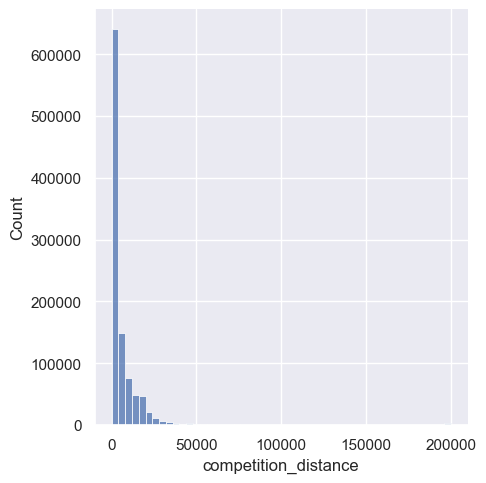

In [237]:
sns.displot( df1['competition_distance'], kde=False, bins = 50)

### 1.7.2 Categorical Attributes

In [238]:
cat_attributes.apply (lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

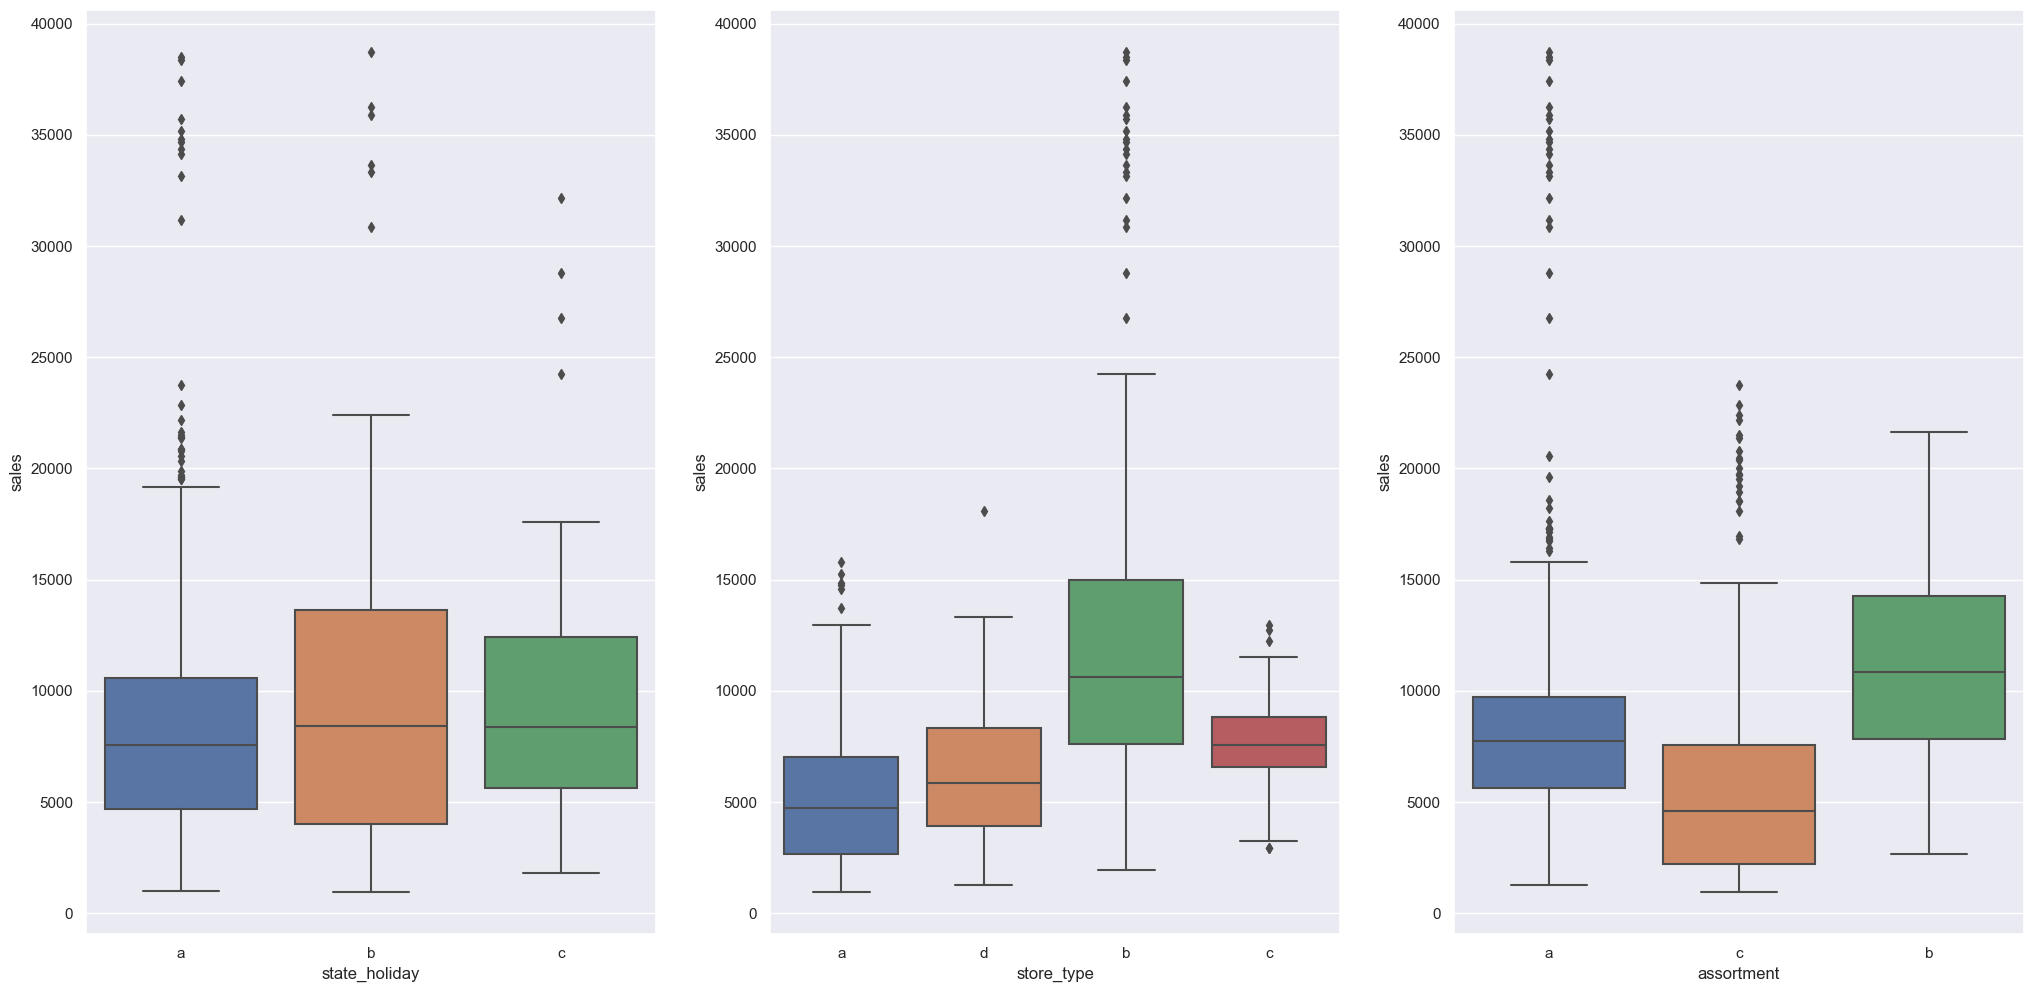

In [239]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0 )]


plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux1 )

# 2.0 Feature Engineering

In [240]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

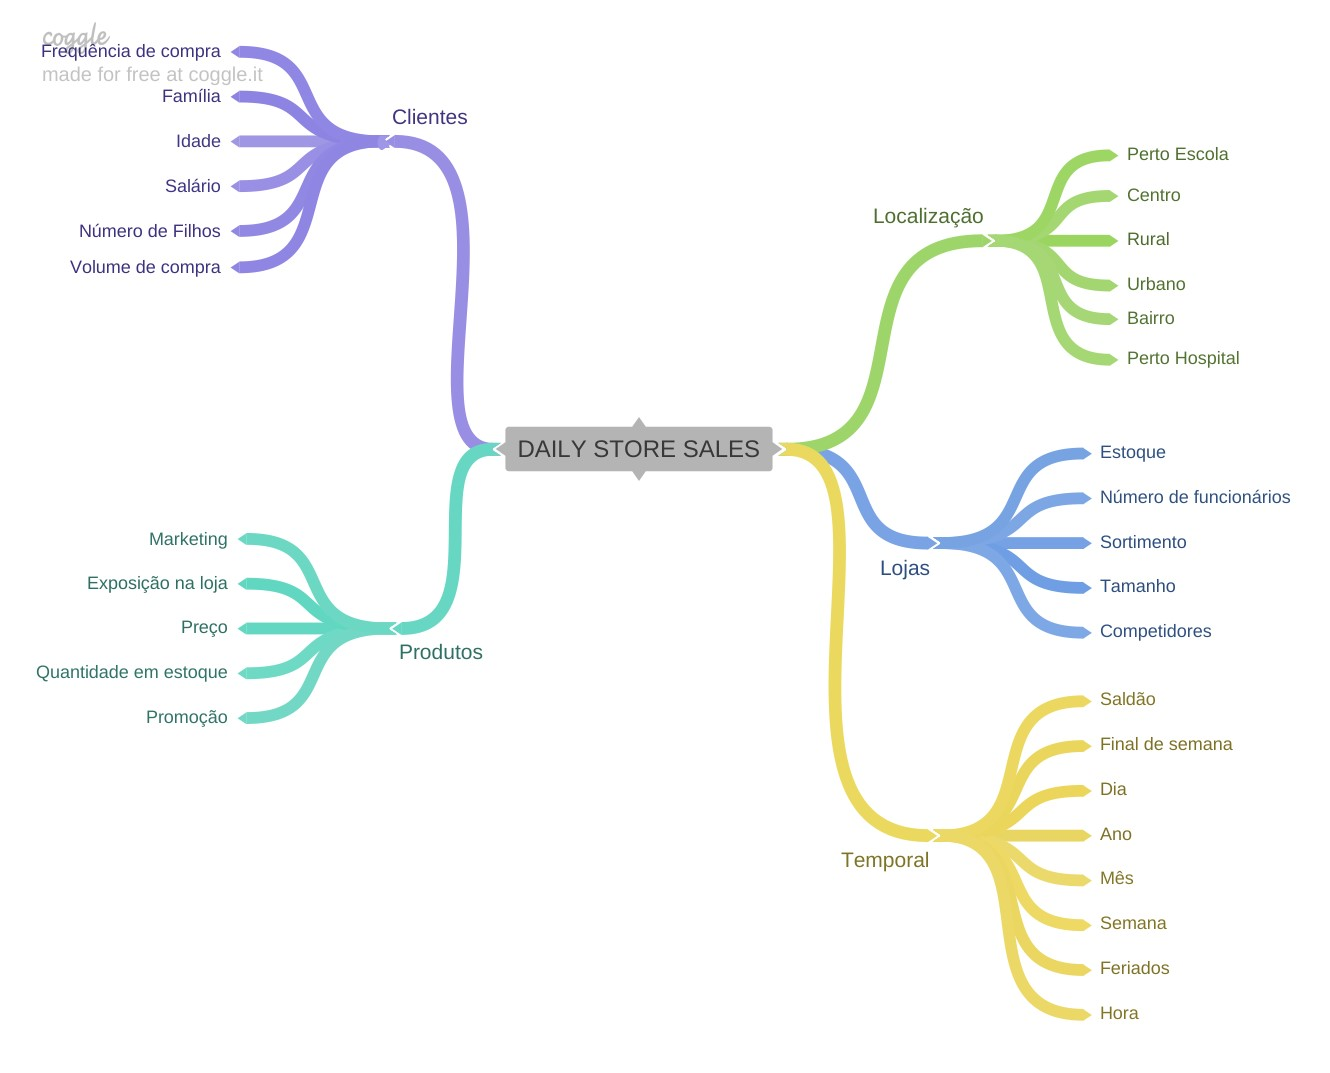

In [241]:
Image.open("img/MIND_MAP_HYPOTESIS_DAILY_STORE_SALE.jpeg")

## 2.2 Criação das Hipóteses

### 2.2.1 Hipóteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com mais estoque vendem mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

In [242]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')
# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

In [243]:
# competition since

df2 ['competition_since'] = df2.apply( lambda x: datetime.datetime ( year = x['competition_open_since_year'],
                                                                     month = x['competition_open_since_month'], 
                                                                     day = 1), axis = 1)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply( lambda x: x.days).astype( 'int64' )

In [244]:
# promo since

df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply( lambda x: x.days).astype( 'int64' )

In [245]:
# assortment de acordo com o data field

df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' 
                                                               else 'extra' if x == 'b' 
                                                               else 'extended' )

In [246]:
# state holiday

df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a'
                                                                              else 'easter_holiday' if x == 'b'
                                                                              else 'christmas' if x == 'c' 
                                                                              else 'regular_day' )

In [247]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Filtragem de Variáveis

In [248]:
df3 = df2.copy()

## 3.1 Filtragem das linhas

In [249]:
linhas_selecionadas = (df3['open'] != 0) & (df3['sales'] > 0)
df3 = df3.loc[ linhas_selecionadas, : ]

## 3.2 Seleção da colunas

In [250]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop (cols_drop, axis = 1)


In [251]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0  Análise Exploratória dos Dados

In [252]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

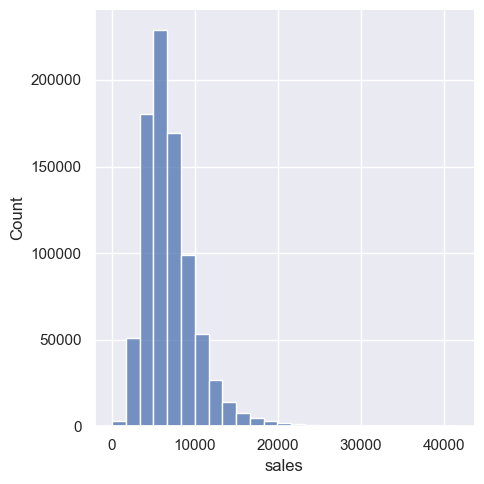

In [253]:
sns.displot(df4['sales'], kde=False, bins = 25)

### 4.1.2 Numerical Variable

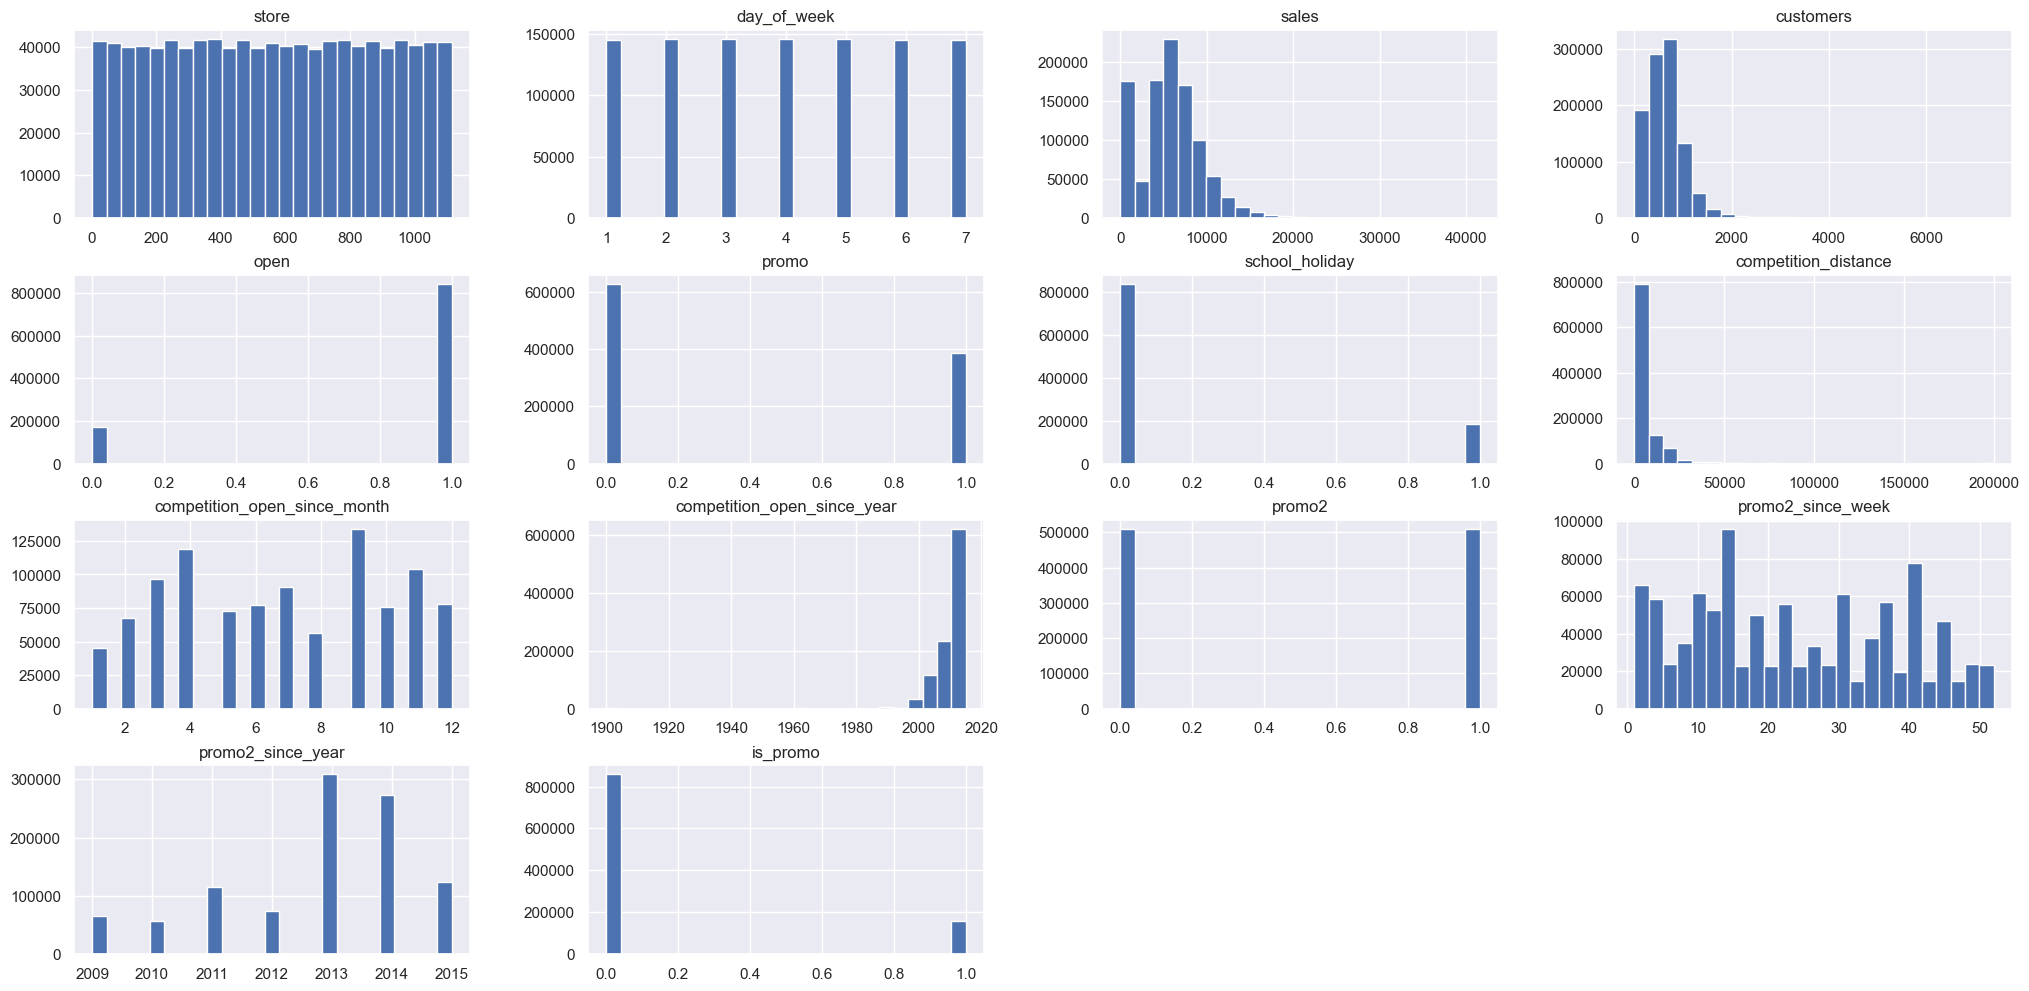

In [254]:
num_attributes.hist( bins = 25 );

### 4.1.3 Categorical Variable

In [255]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [256]:
# state holiday
df4['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

In [257]:
linhas_selecionadas = df4['state_holiday'] != 'regular_day'
df_aux = df4.loc[linhas_selecionadas, :].reset_index()

<Axes: xlabel='sales', ylabel='Density'>

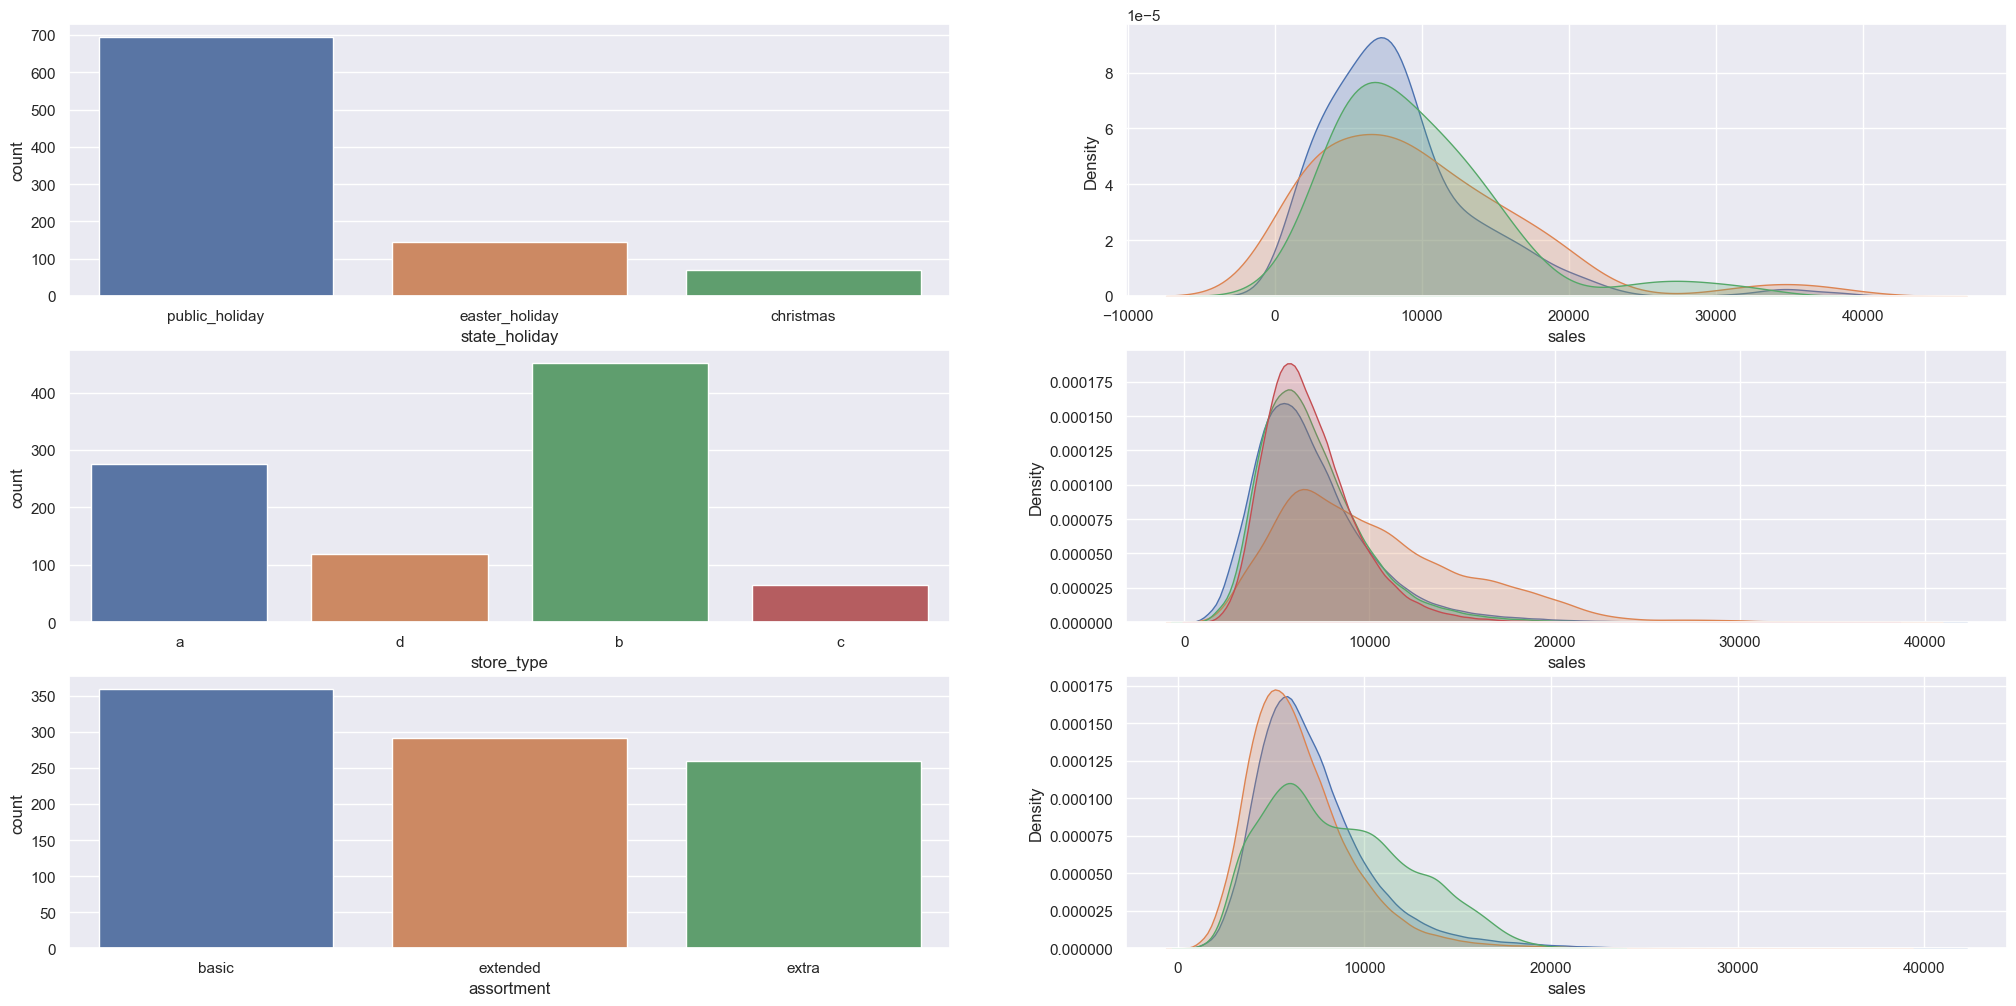

In [258]:
# state_holiday
plt.subplot( 3, 2, 1 )
sns.countplot(x='state_holiday', data=df_aux)

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True )

# store type

plt.subplot( 3, 2, 3 )
sns.countplot(x='store_type', data=df_aux)

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', fill=True )


# assortment

plt.subplot( 3, 2, 5 )
sns.countplot(x='assortment', data=df_aux)

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True )

## 4.2 Análise Bivariada

### **H1.** Lojas com maior sortimentos deveriam vender mais.

**Falsa**  - Lojas com MAIOR SORTIMENTO vendem MENOS

<Axes: xlabel='year_week'>

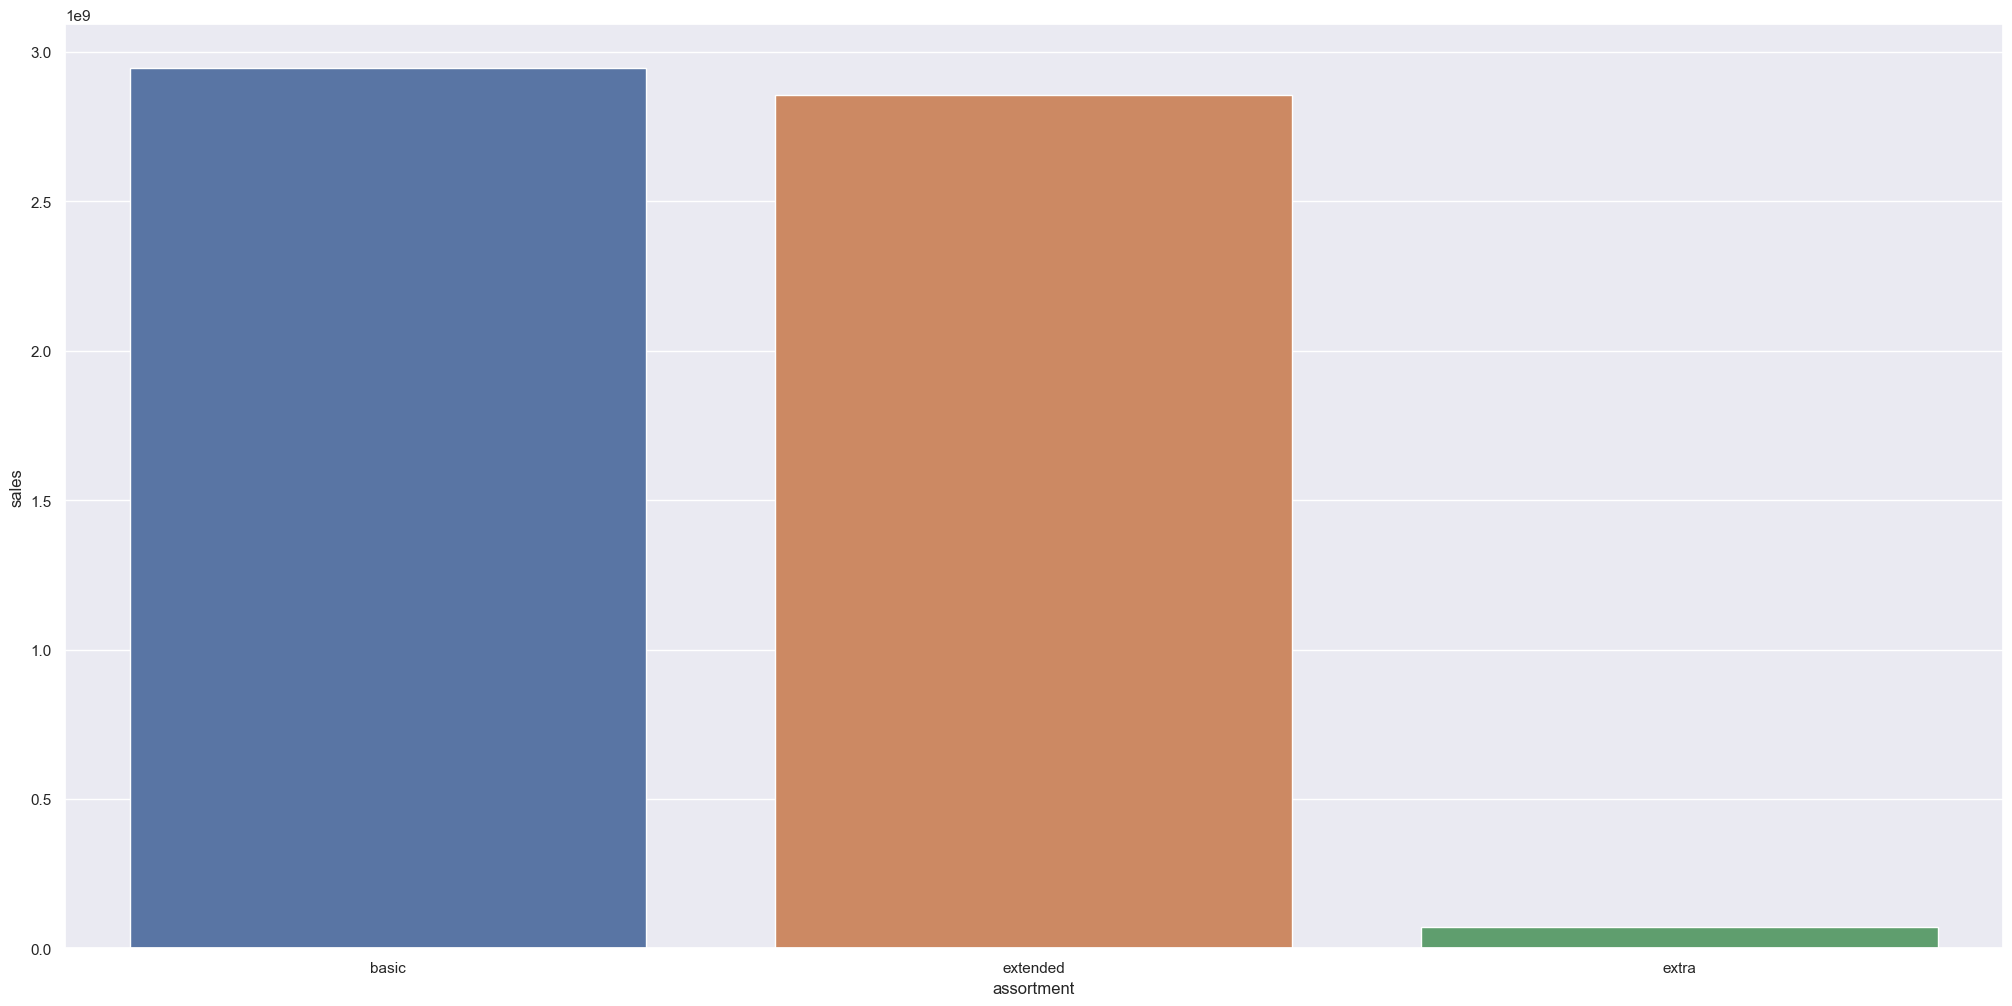

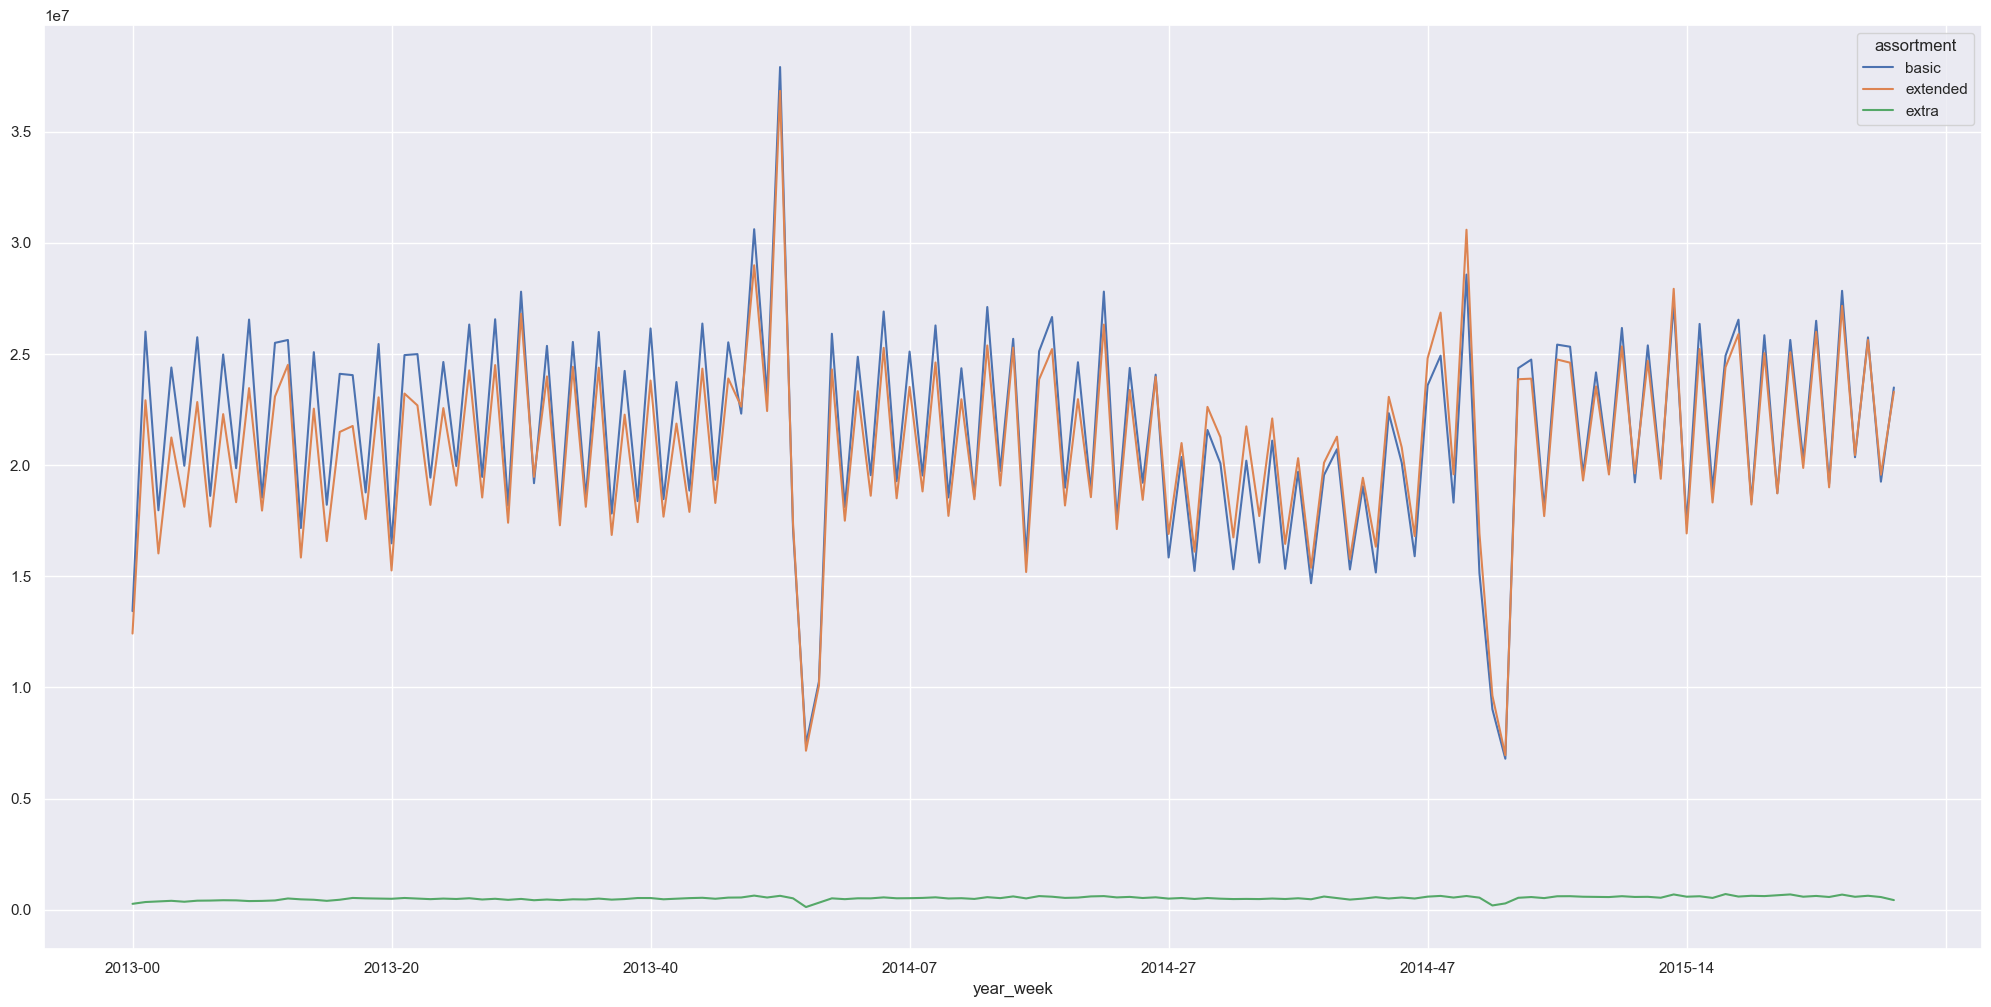

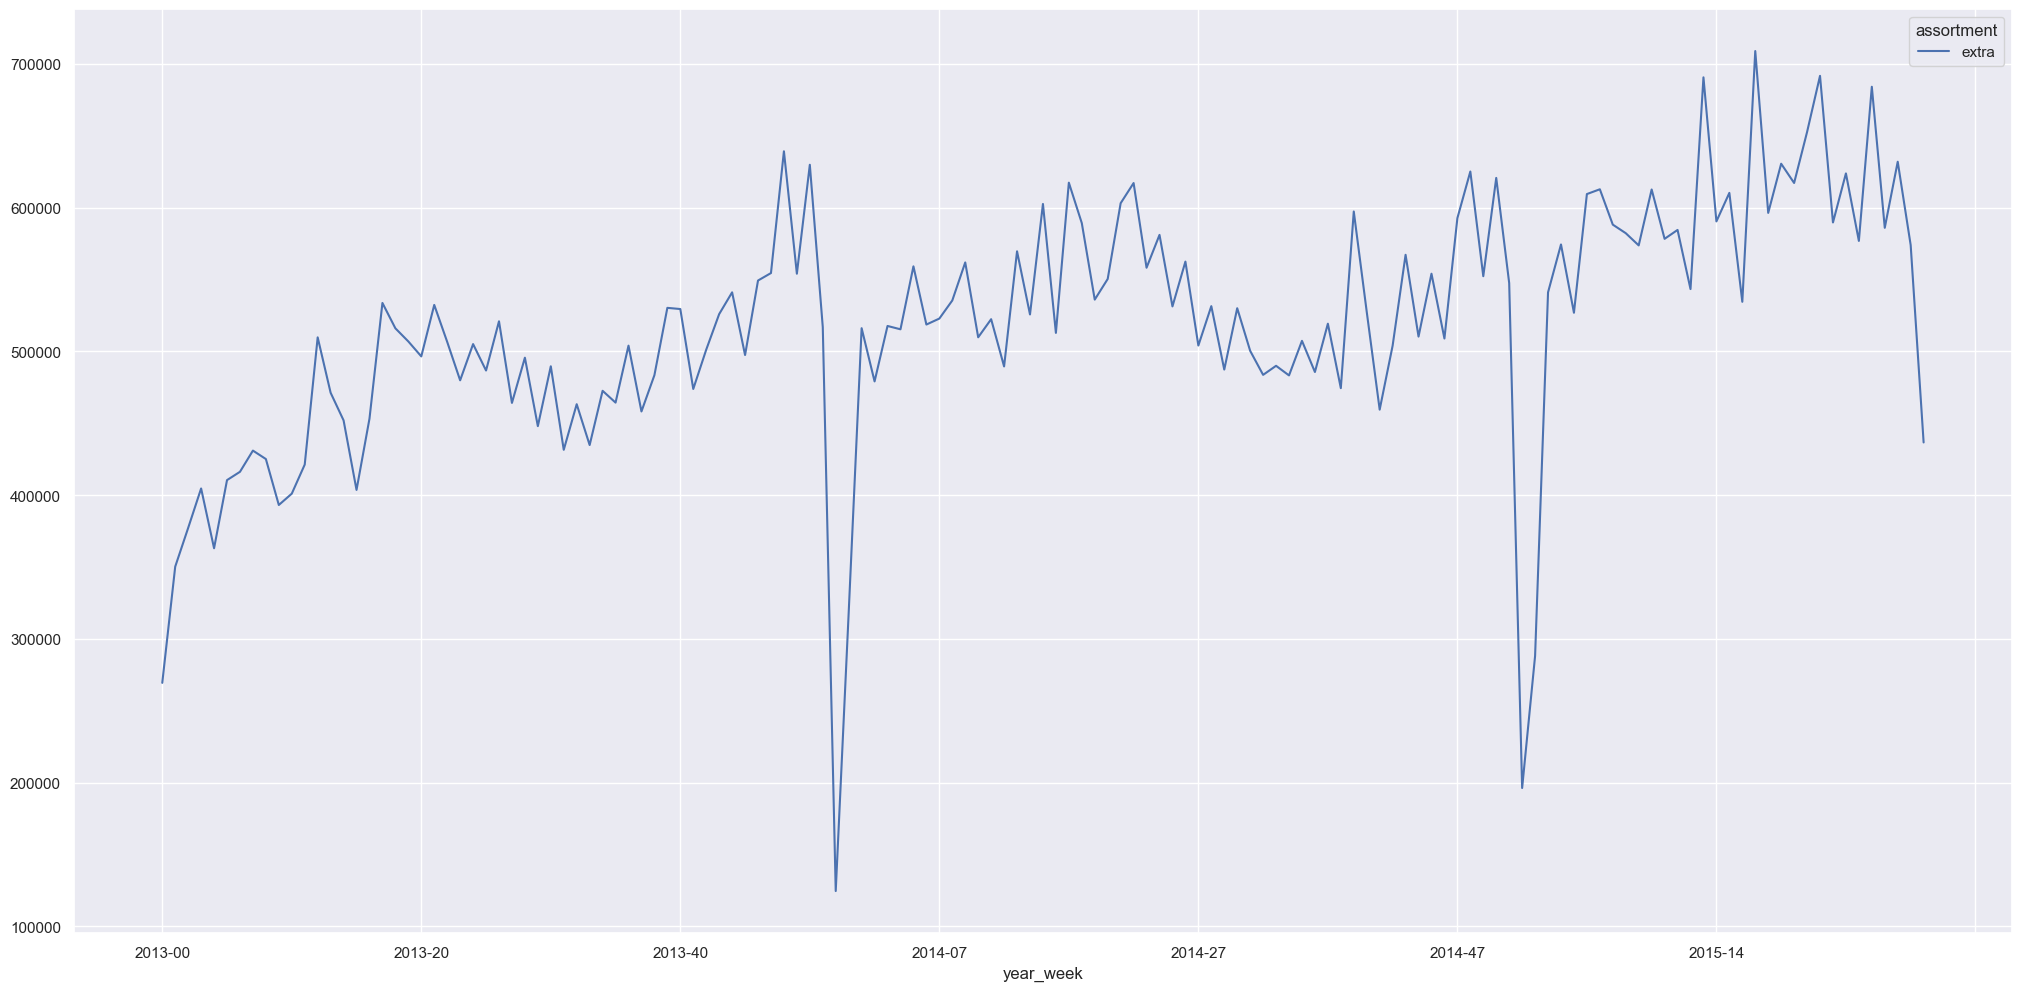

In [259]:
df_aux = df4.loc[:, ['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = df_aux);

df_aux2 = df_aux = df4.loc[:, ['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
df_aux2.pivot ( index = 'year_week', columns = 'assortment', values = 'sales' ).plot()


df_aux3 = df_aux2[df_aux2['assortment'] == 'extra']
df_aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**Falsa**  - Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS

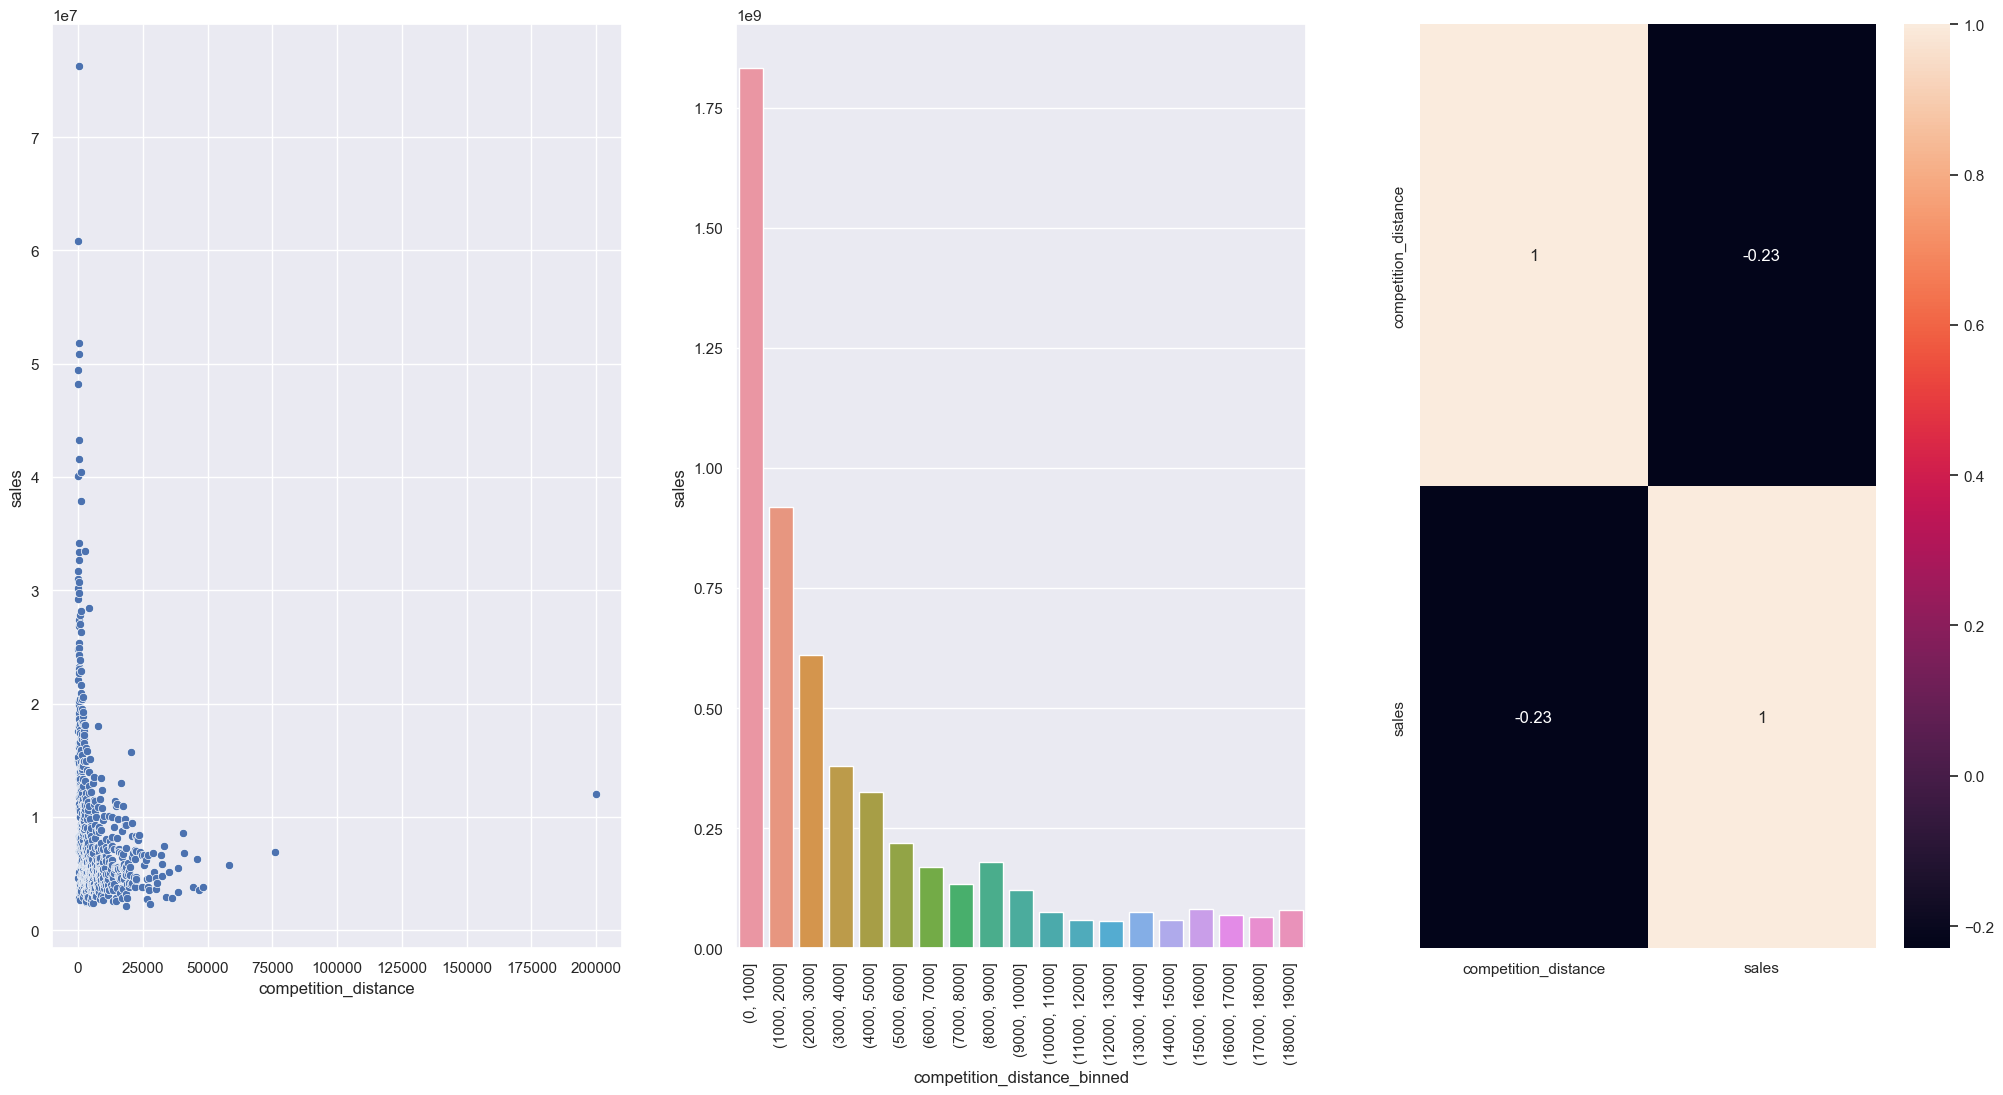

In [260]:
df_aux = df4.loc[:, ['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot(x = 'competition_distance', y = 'sales', data = df_aux);

plt.subplot( 1, 3, 2 )
bins = list(np.arange (0, 20000, 1000))
df_aux['competition_distance_binned'] = pd.cut ( df_aux['competition_distance'], bins = bins )
df_aux2 = df_aux.loc[:, ['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = df_aux2);
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( df_aux.corr( method='pearson', numeric_only=True ), annot=True );

### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.

**Falsa** - Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

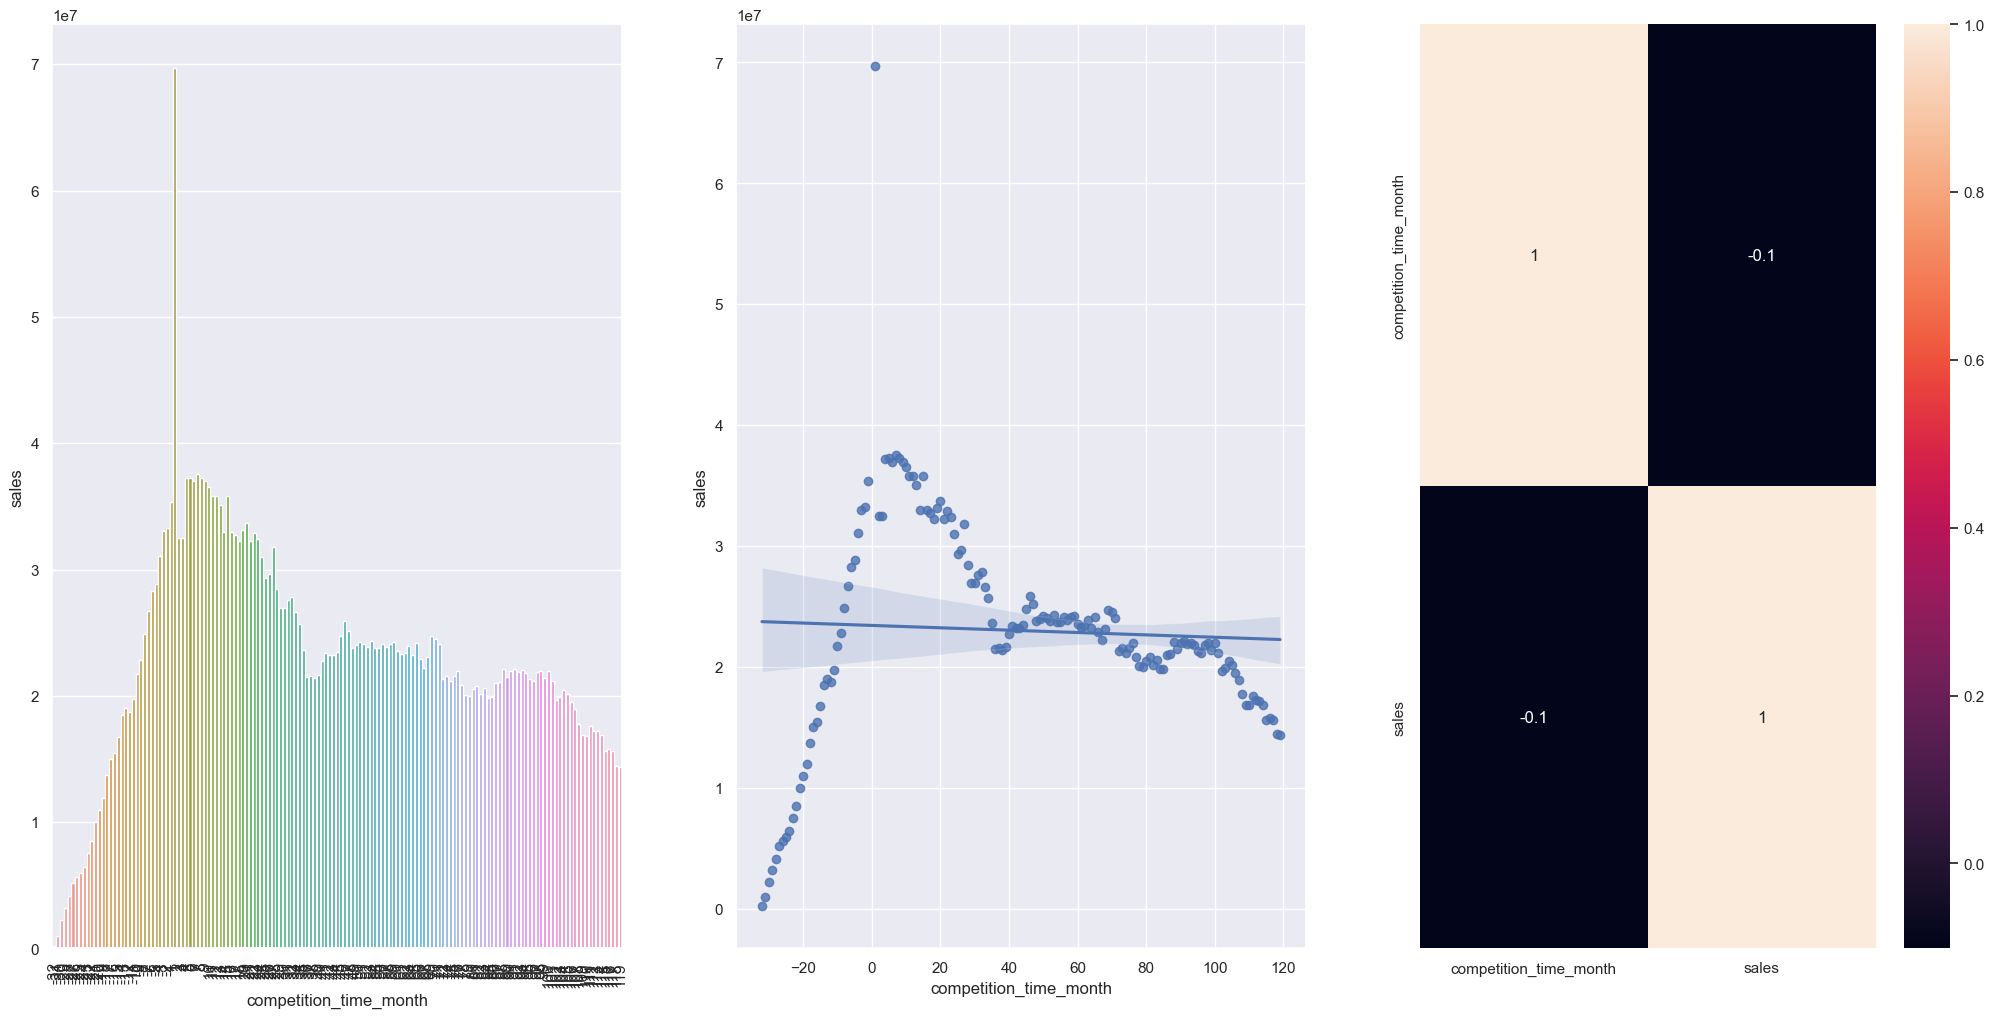

In [261]:
df_aux = df4.loc[:, ['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

linhas_selecionadas = (df_aux['competition_time_month'] < 120) & (df_aux['competition_time_month'] != 0)
df_aux2 = df_aux.loc[linhas_selecionadas, :]

plt.subplot( 1, 3, 1 )
sns.barplot(x = 'competition_time_month', y = 'sales', data = df_aux2);
plt.xticks( rotation=90 );


plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=df_aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( df_aux.corr( method='pearson', numeric_only=True), annot=True );

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**Falsa** - Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo
de promoção

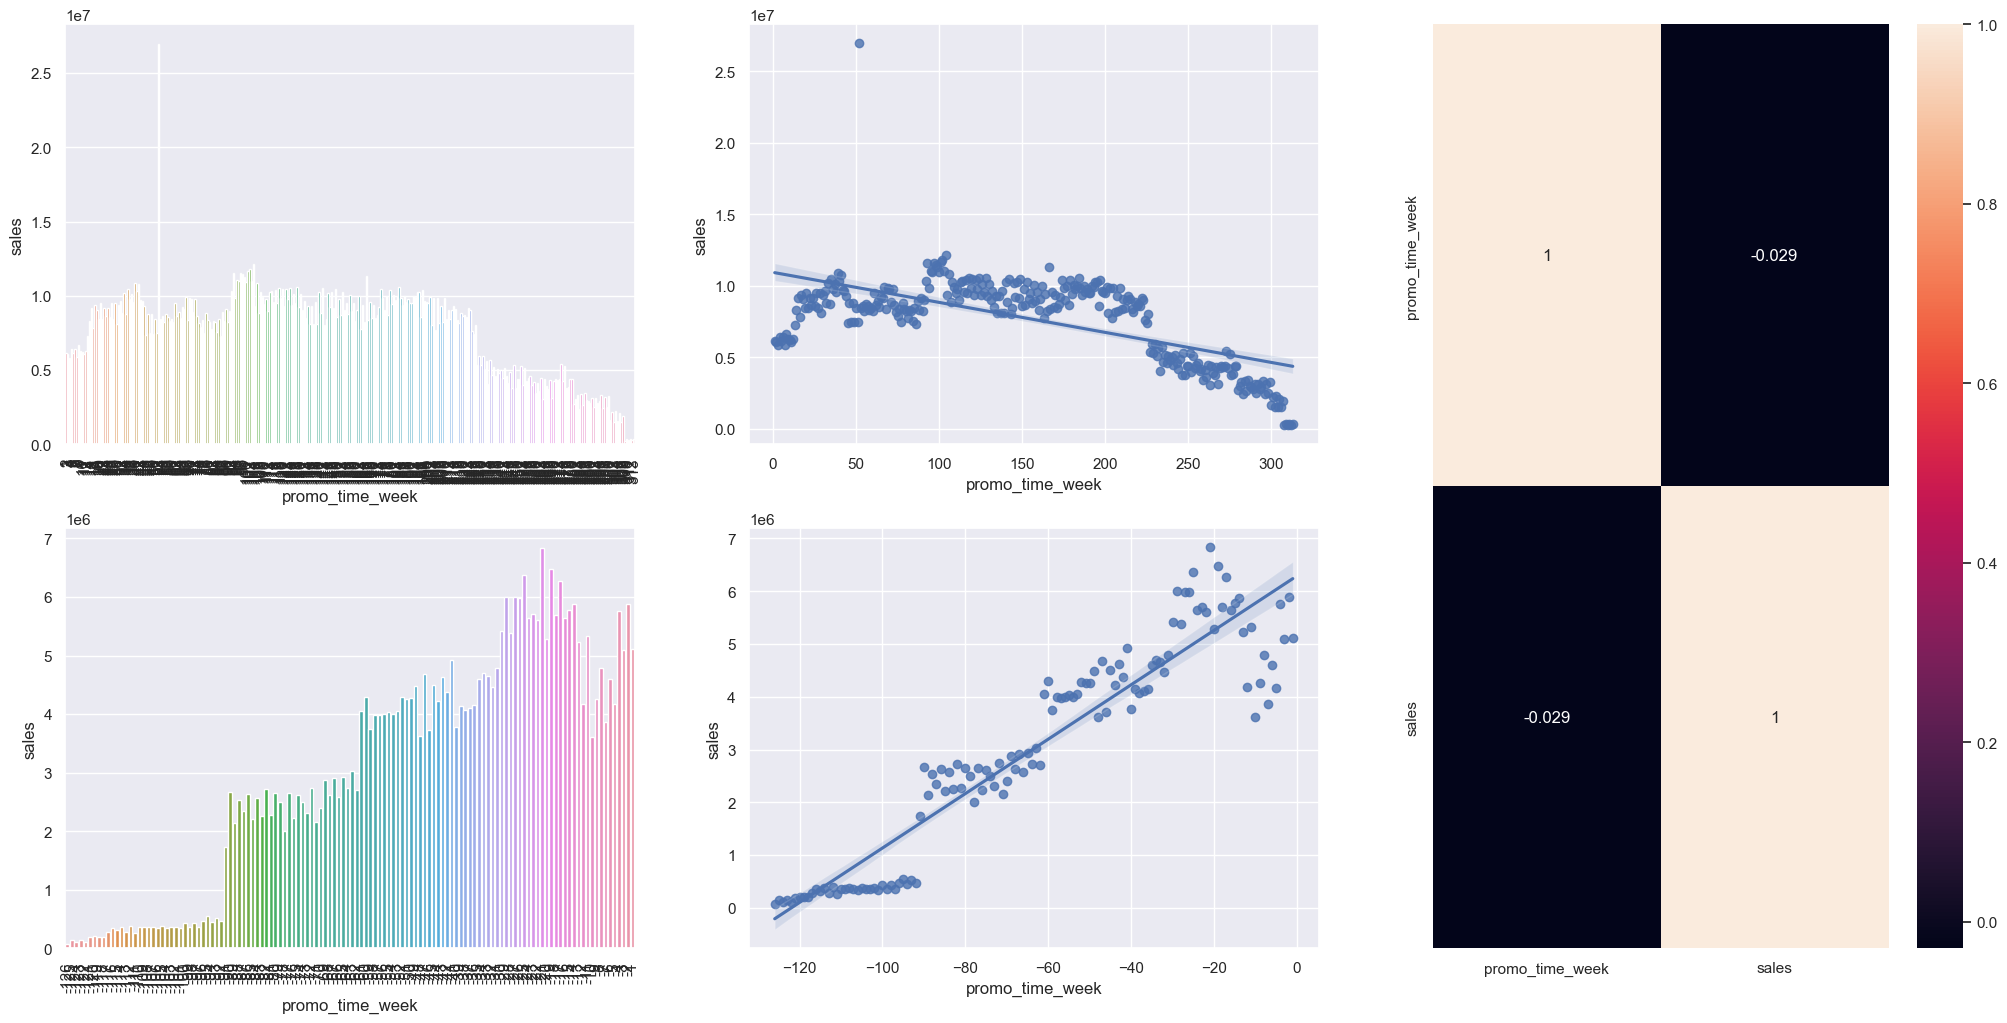

In [262]:
df_aux = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
df_aux2 = df_aux[df_aux['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=df_aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=df_aux2 );

plt.subplot( grid[1,0] )
df_aux3 = df_aux[df_aux['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=df_aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=df_aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( df_aux.corr( method='pearson', numeric_only=True ), annot=True );

### **H5.** Lojas com mais dias de promoção deveriam vender mais.

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**Falsa** - Lojas com mais promocoes consecutivas vendem menos

In [263]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


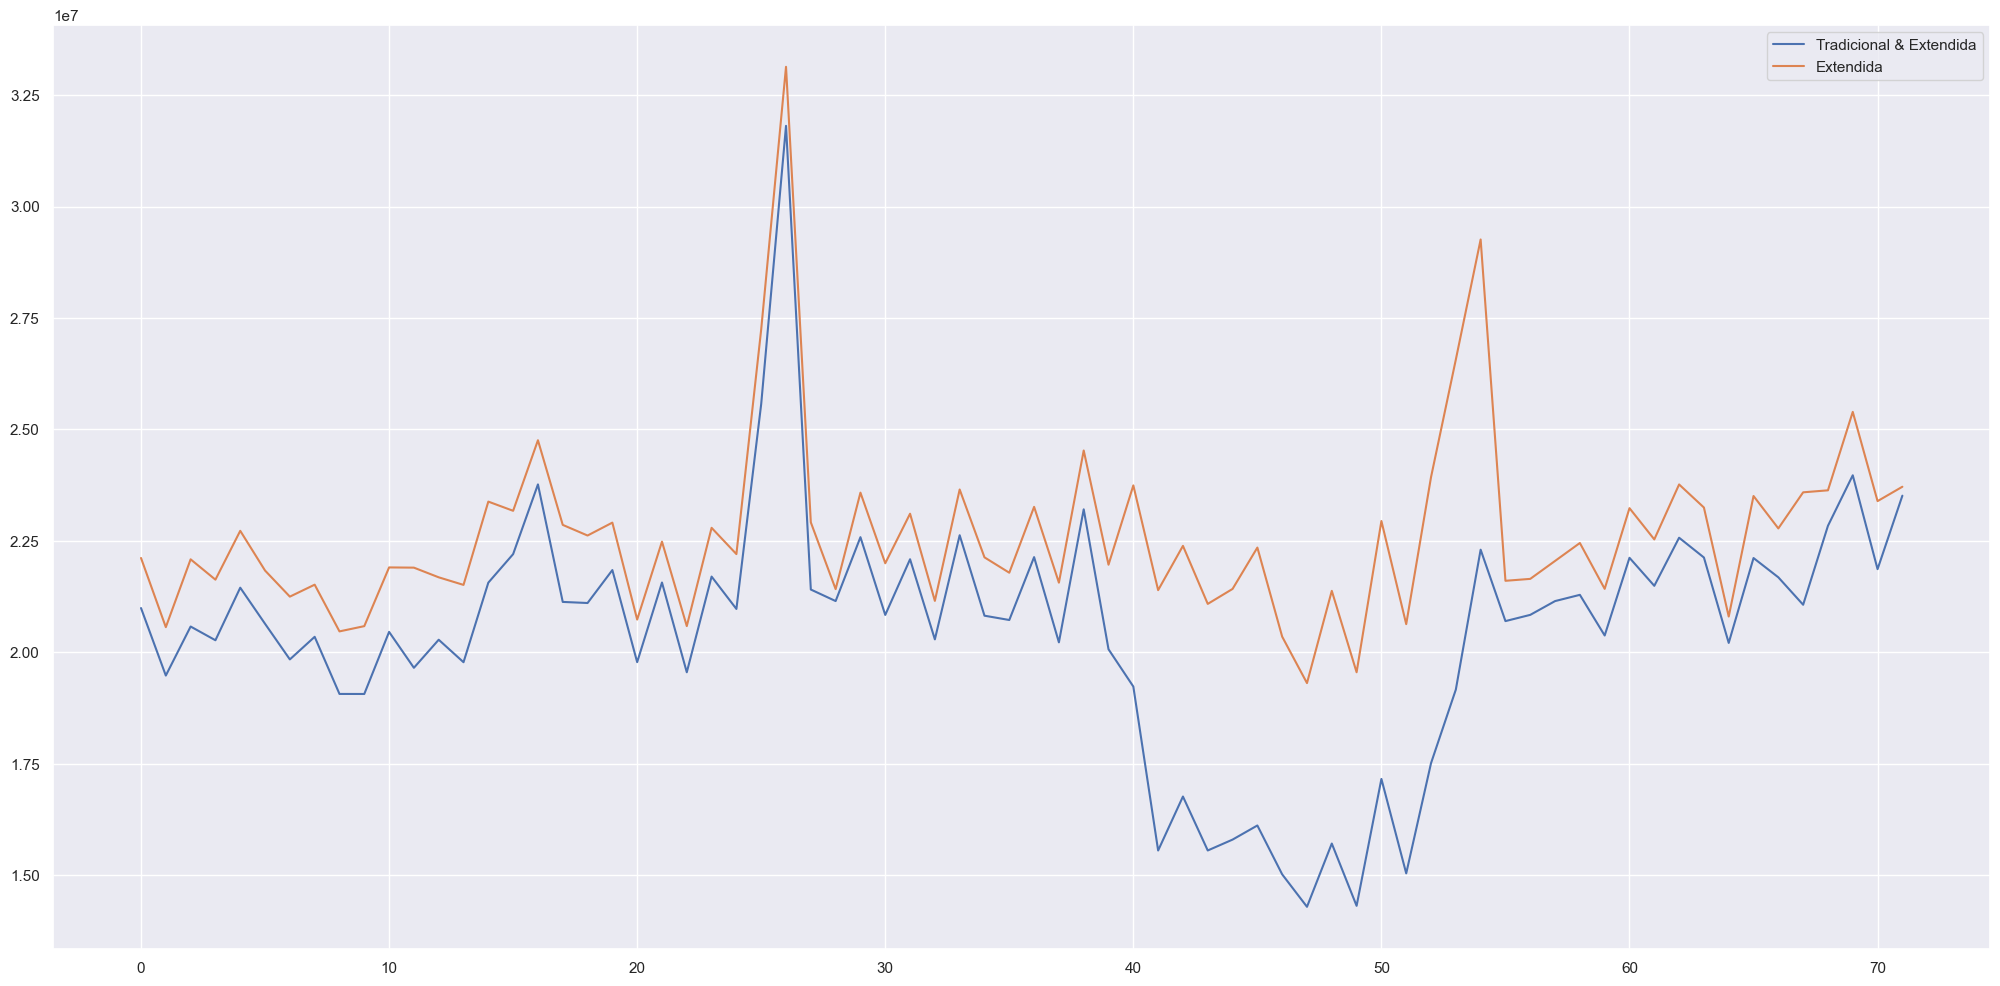

In [264]:
linhas_selecionadas = (df4['promo'] == 1) & (df4['promo2'] == 1)
df_aux = df4.loc[linhas_selecionadas, ['year_week','sales']].groupby('year_week').sum().reset_index()
ax = df_aux.plot()

linhas_selecionadas2 = (df4['promo'] == 1) & (df4['promo2'] == 0)
df_aux2 = df4.loc[linhas_selecionadas2, ['year_week','sales']].groupby('year_week').sum().reset_index()
df_aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);


### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**Falsa** - Lojas abertas durante o feriado do Natal vendem menos.

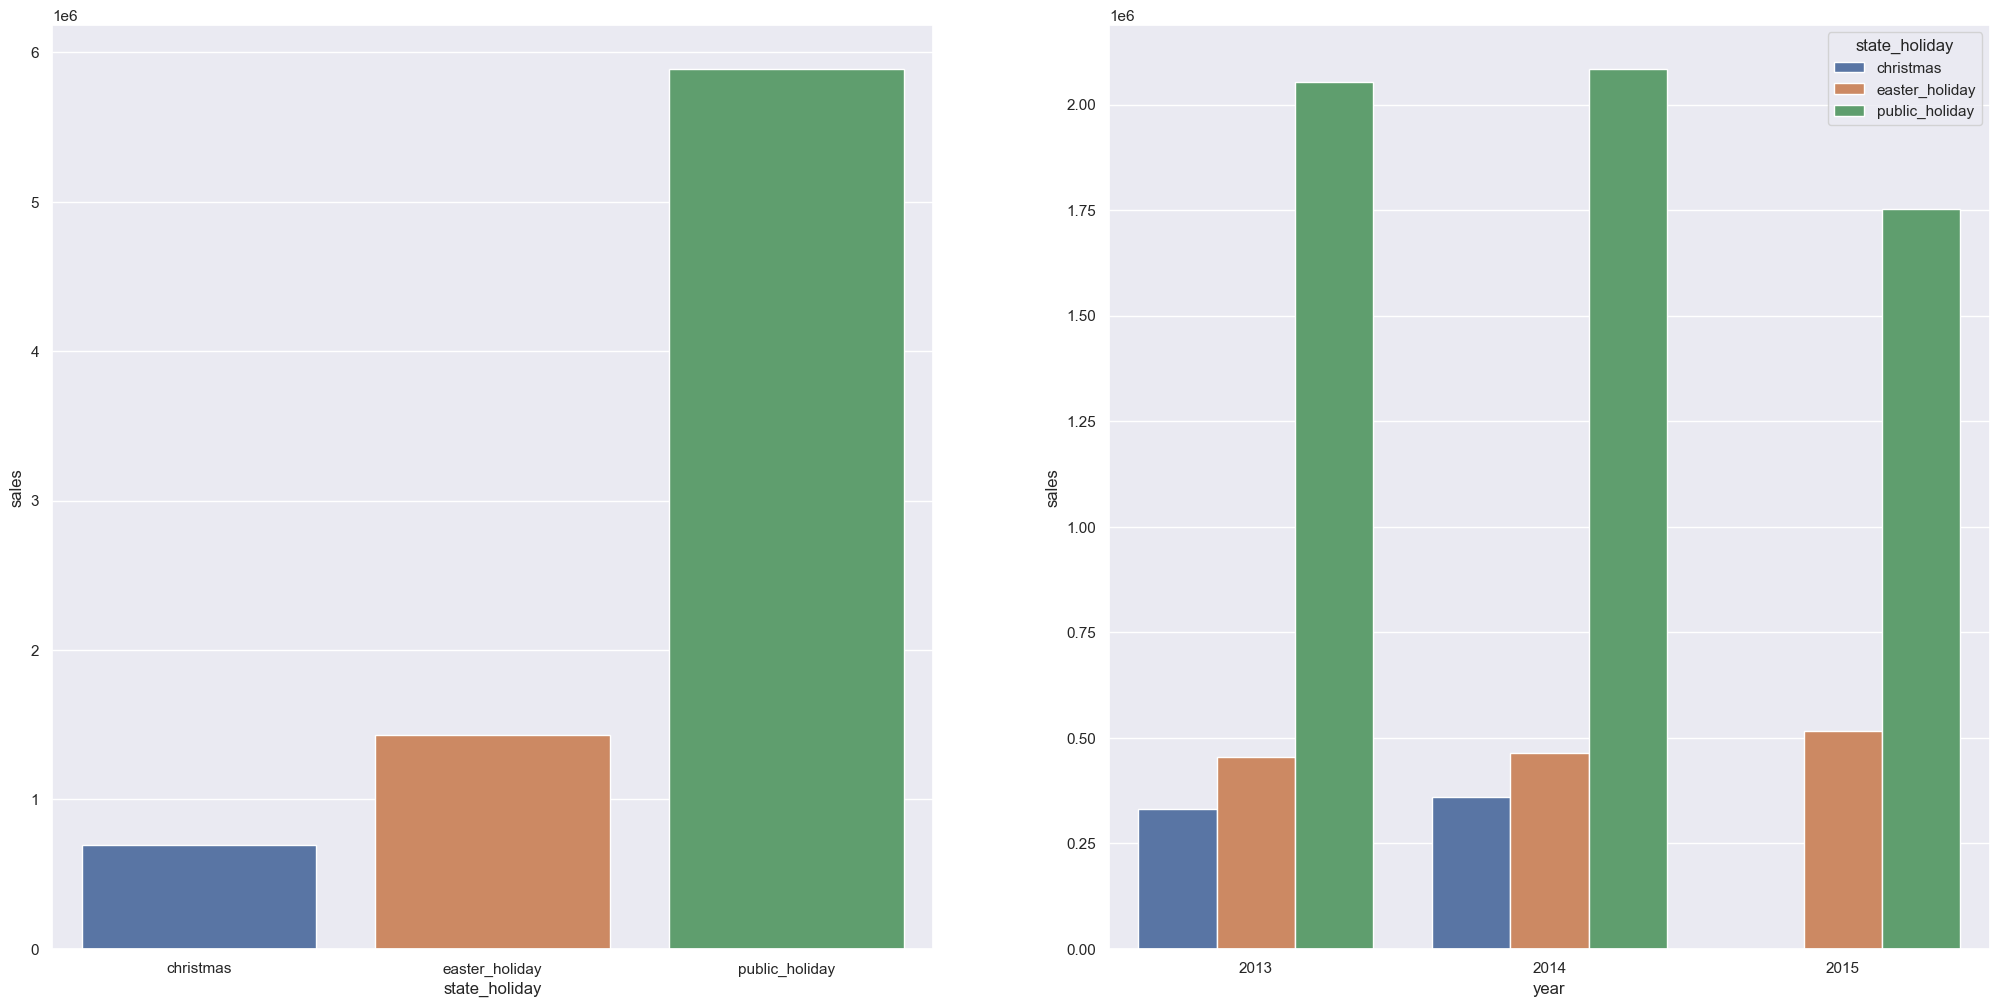

In [265]:
linhas_selecionadas = df4['state_holiday'] != 'regular_day'

plt.subplot( 1 , 2 , 1 )
df_aux = df4.loc[linhas_selecionadas, ['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = df_aux);

plt.subplot( 1 , 2 , 2 )
df_aux2 = df4.loc[linhas_selecionadas, ['year','state_holiday', 'sales']].groupby( ['state_holiday','year'] ).sum().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', data = df_aux2);


### **H8.** Lojas deveriam vender mais ao longo dos anos.
**Falsa** -  Lojas vendem menos ao longo dos anos

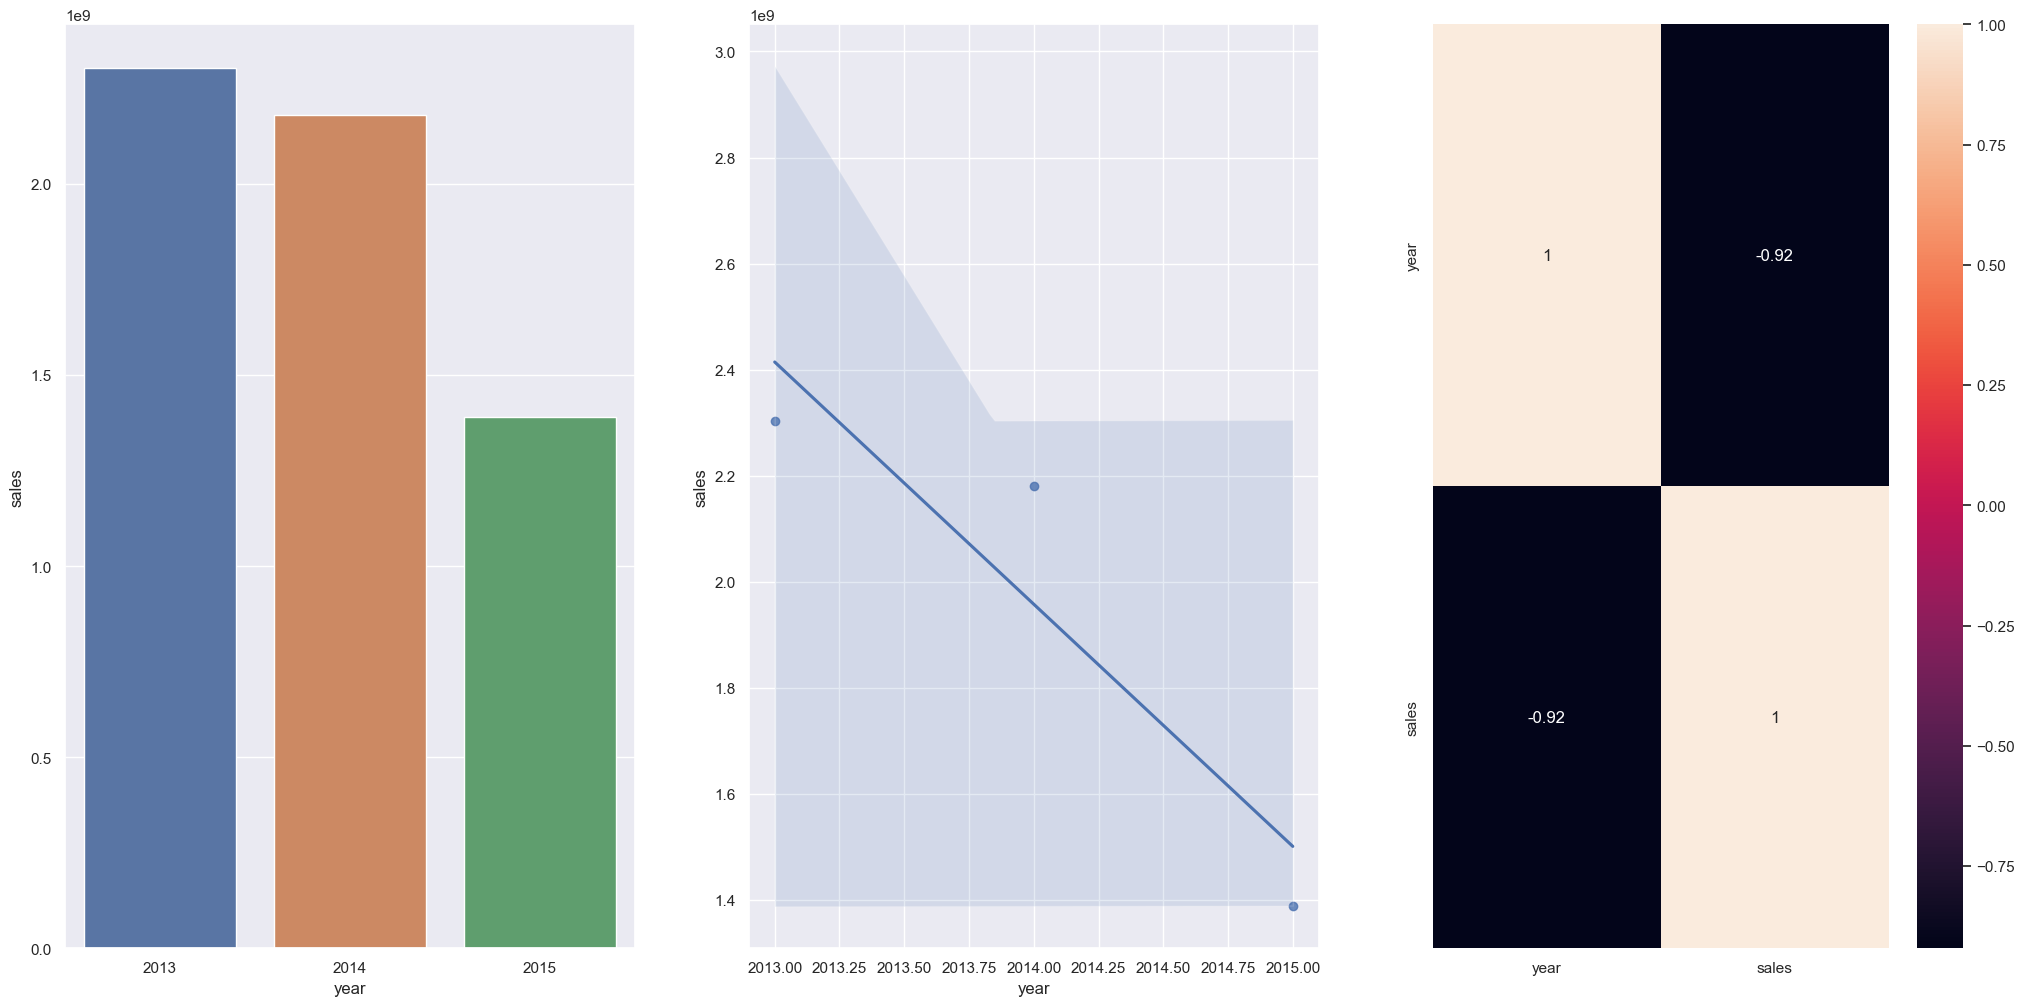

In [266]:
df_aux = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot (1 , 3 , 1)
sns.barplot(x = 'year', y = 'sales', data = df_aux);

plt.subplot (1, 3 ,2)
sns.regplot( x='year', y='sales', data=df_aux );

plt.subplot (1, 3 ,3)
sns.heatmap( df_aux.corr( method='pearson', numeric_only=True ), annot=True );

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**Falsa** - Lojas vendem menos no segundo semestre do ano

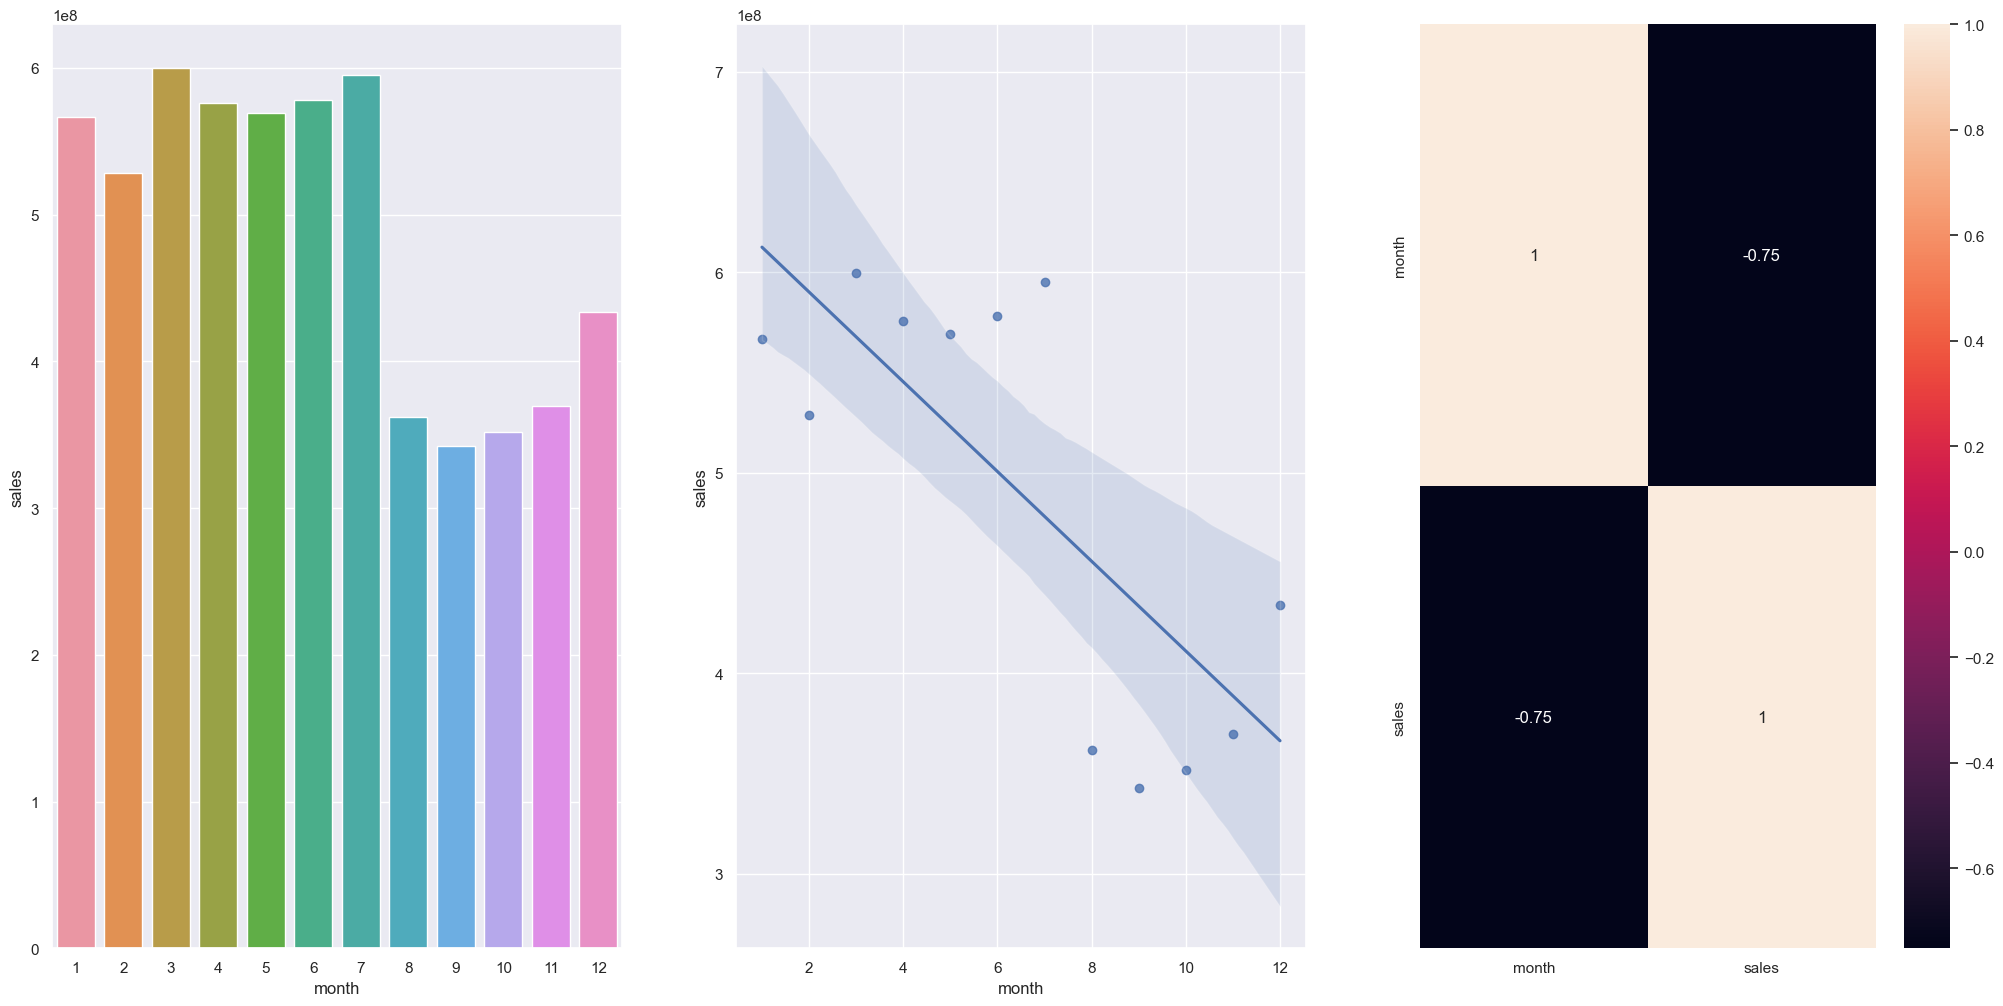

In [267]:
df_aux = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot (1 , 3 , 1)
sns.barplot(x = 'month', y = 'sales', data = df_aux);

plt.subplot (1, 3 ,2)
sns.regplot( x='month', y='sales', data=df_aux );

plt.subplot (1, 3 ,3)
sns.heatmap( df_aux.corr( method='pearson', numeric_only=True ), annot=True );

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**Verdadeira** - Lojas vendem mais depois do dia 10 de cada mes.

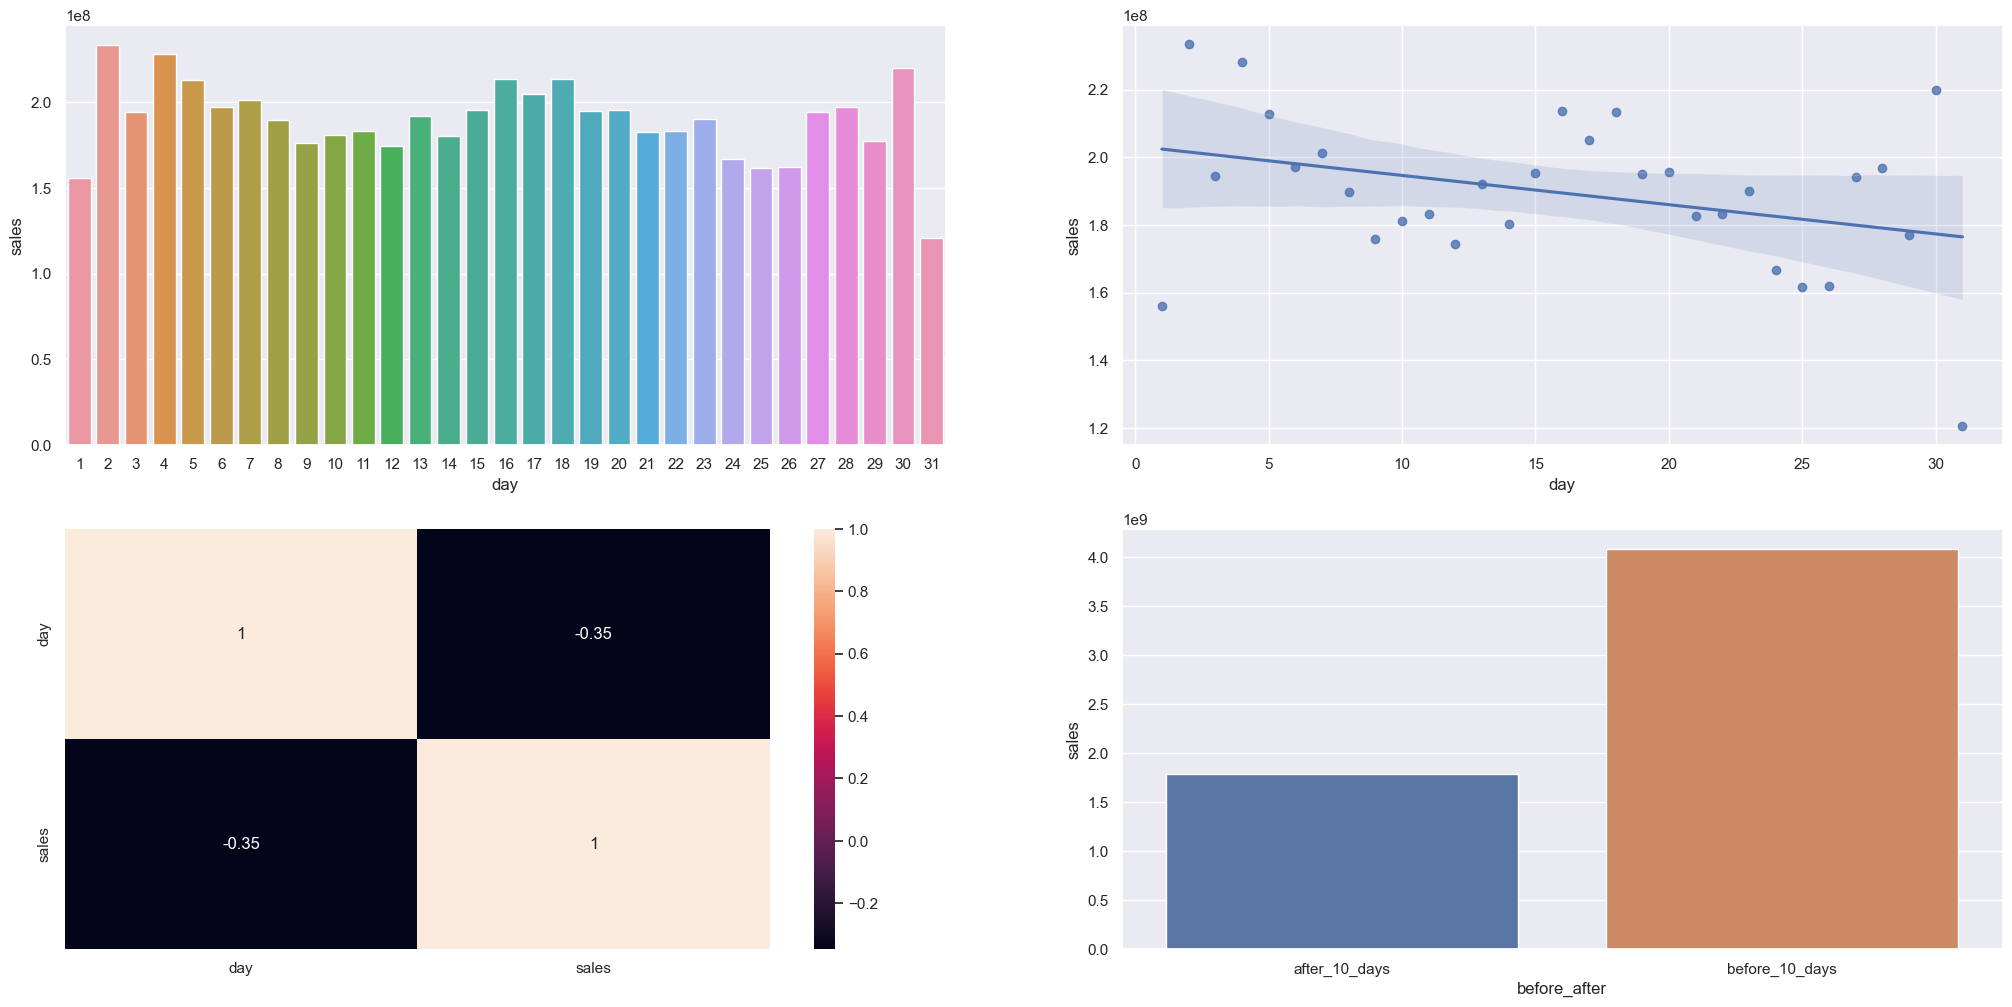

In [268]:
df_aux = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot (2 , 2 , 1 )
sns.barplot(x = 'day', y = 'sales', data = df_aux);

plt.subplot (2 , 2 , 2 )
sns.regplot( x='day', y='sales', data=df_aux );

plt.subplot (2, 2 , 3 )
sns.heatmap( df_aux.corr( method='pearson', numeric_only=True ), annot=True );

df_aux['before_after'] = df_aux['day'].apply(lambda x: 'before_10_days' if x >= 10 else 'after_10_days')


plt.subplot (2, 2 ,4 )
df_aux2 = df_aux[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()
sns.barplot(x = 'before_after', y = 'sales', data = df_aux2);

### **H11.** Lojas deveriam vender menos aos finais de semana.
**Verdadeira** - Lojas vendem menos nos final de semana.

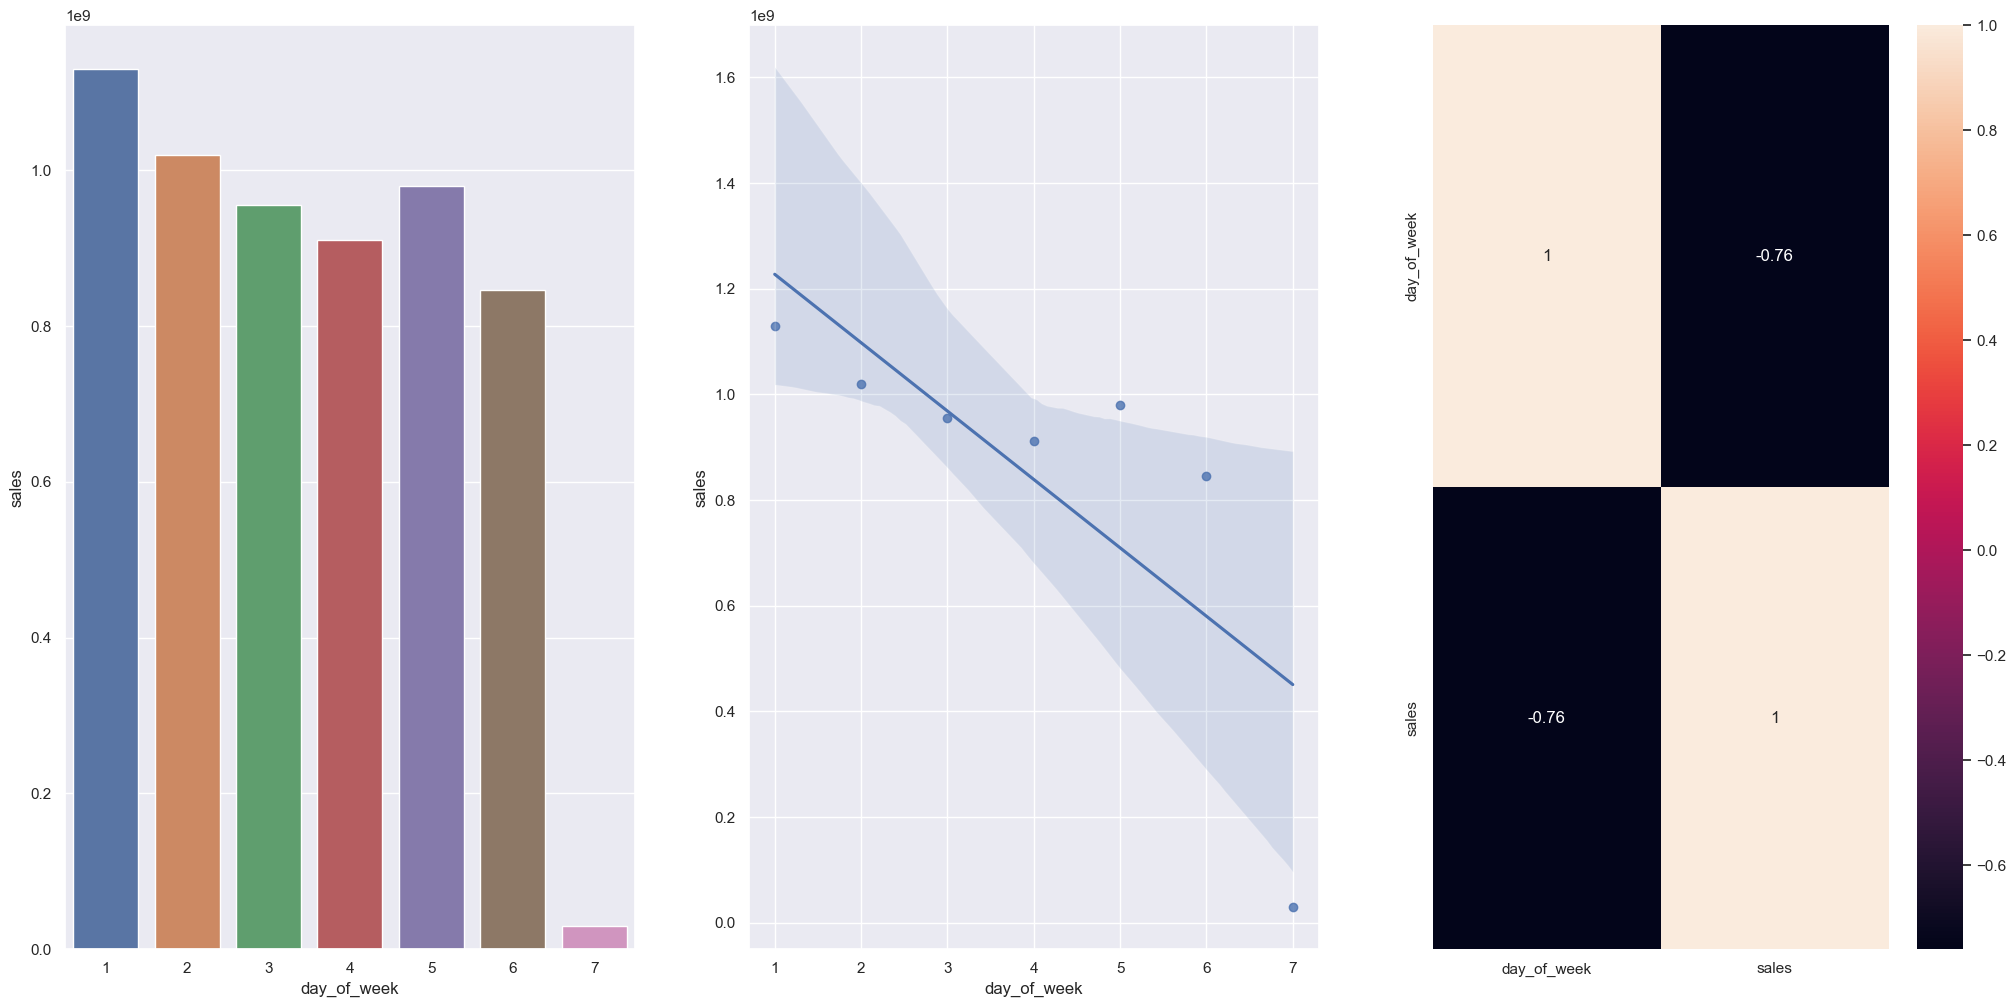

In [269]:
df_aux = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot (1 , 3 , 1)
sns.barplot(x = 'day_of_week', y = 'sales', data = df_aux);

plt.subplot (1, 3 ,2)
sns.regplot( x='day_of_week', y='sales', data=df_aux );

plt.subplot (1, 3 ,3)
sns.heatmap( df_aux.corr( method='pearson', numeric_only=True ), annot=True );

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
**Verdadeira** - Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e
Agosto.

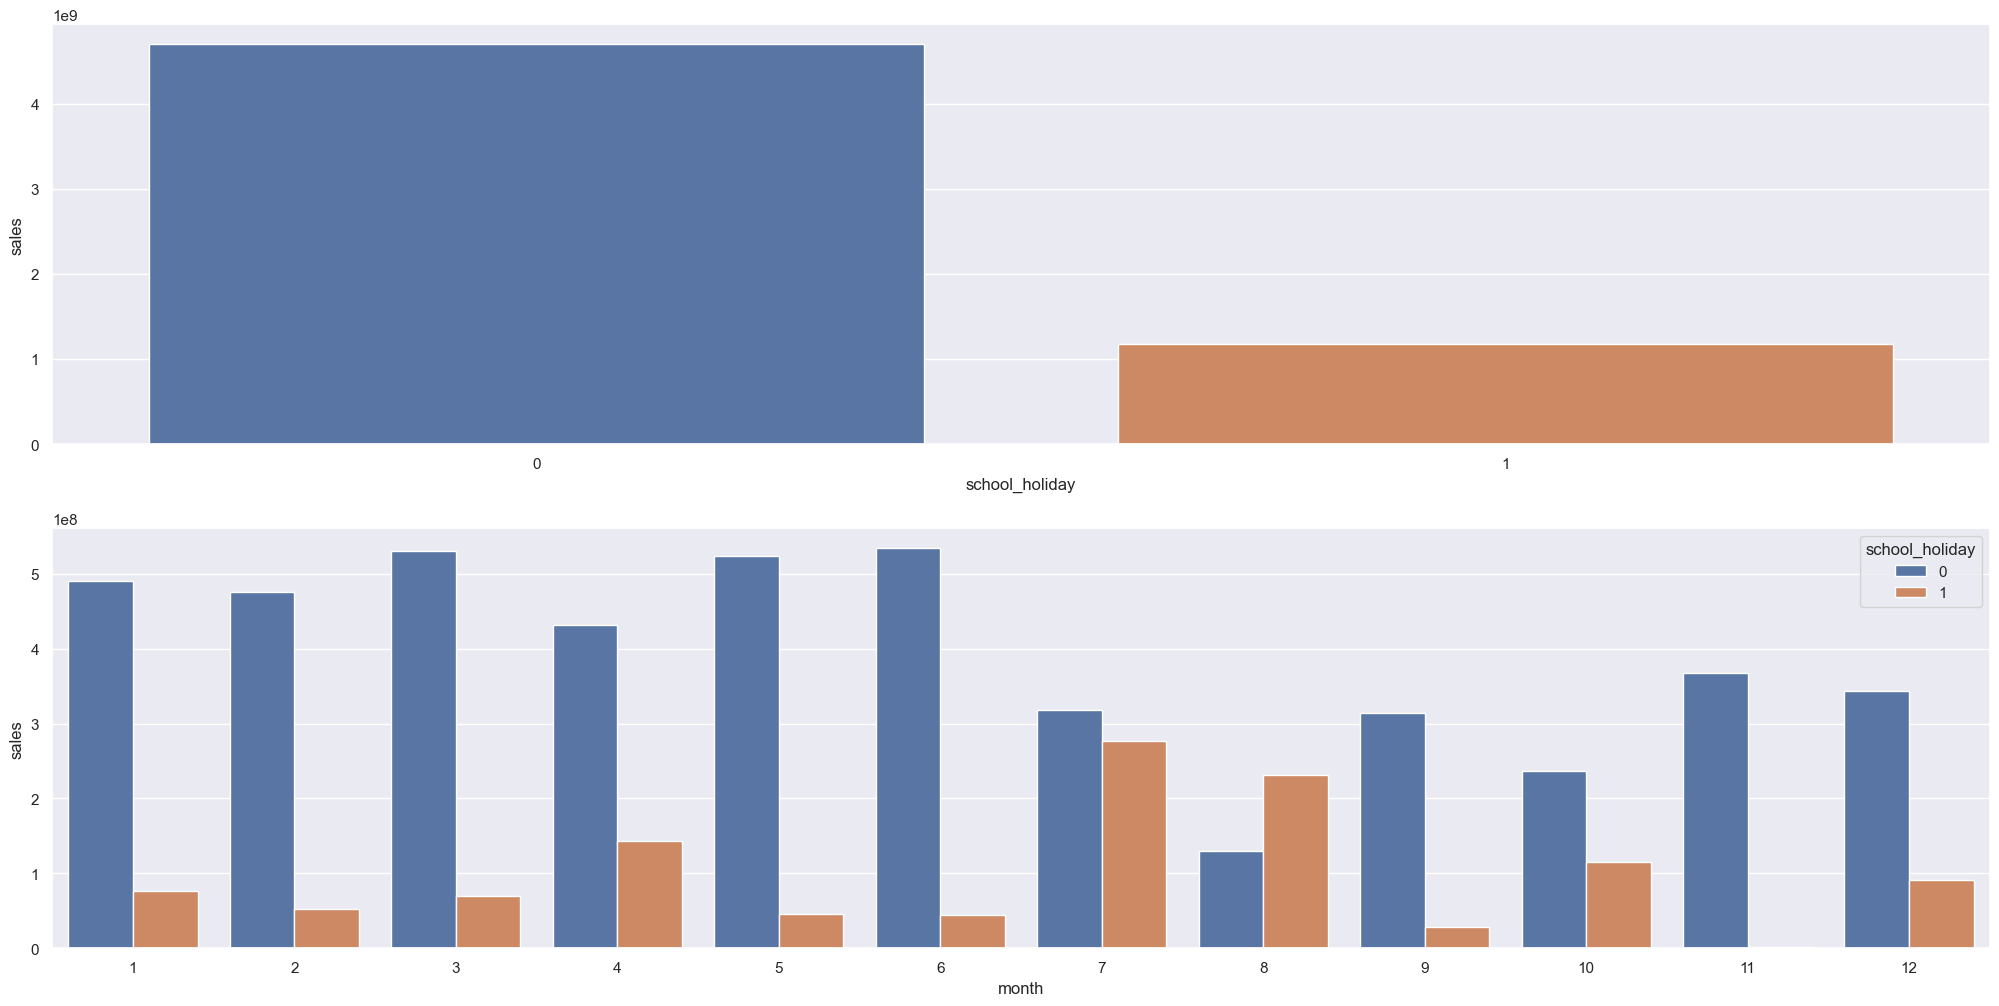

In [270]:
df_aux = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

plt.subplot (2 , 1 , 1)
sns.barplot(x = 'school_holiday', y = 'sales', data = df_aux);

df_aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()

plt.subplot (2, 1 ,2)
sns.barplot( x='month', y='sales', hue='school_holiday', data=df_aux2 );

### 4.2.1 Resumo das Hipóteses

In [271]:
from tabulate import tabulate

In [272]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3 Análise Multivariada

### 4.3.1. Numerical Attributes

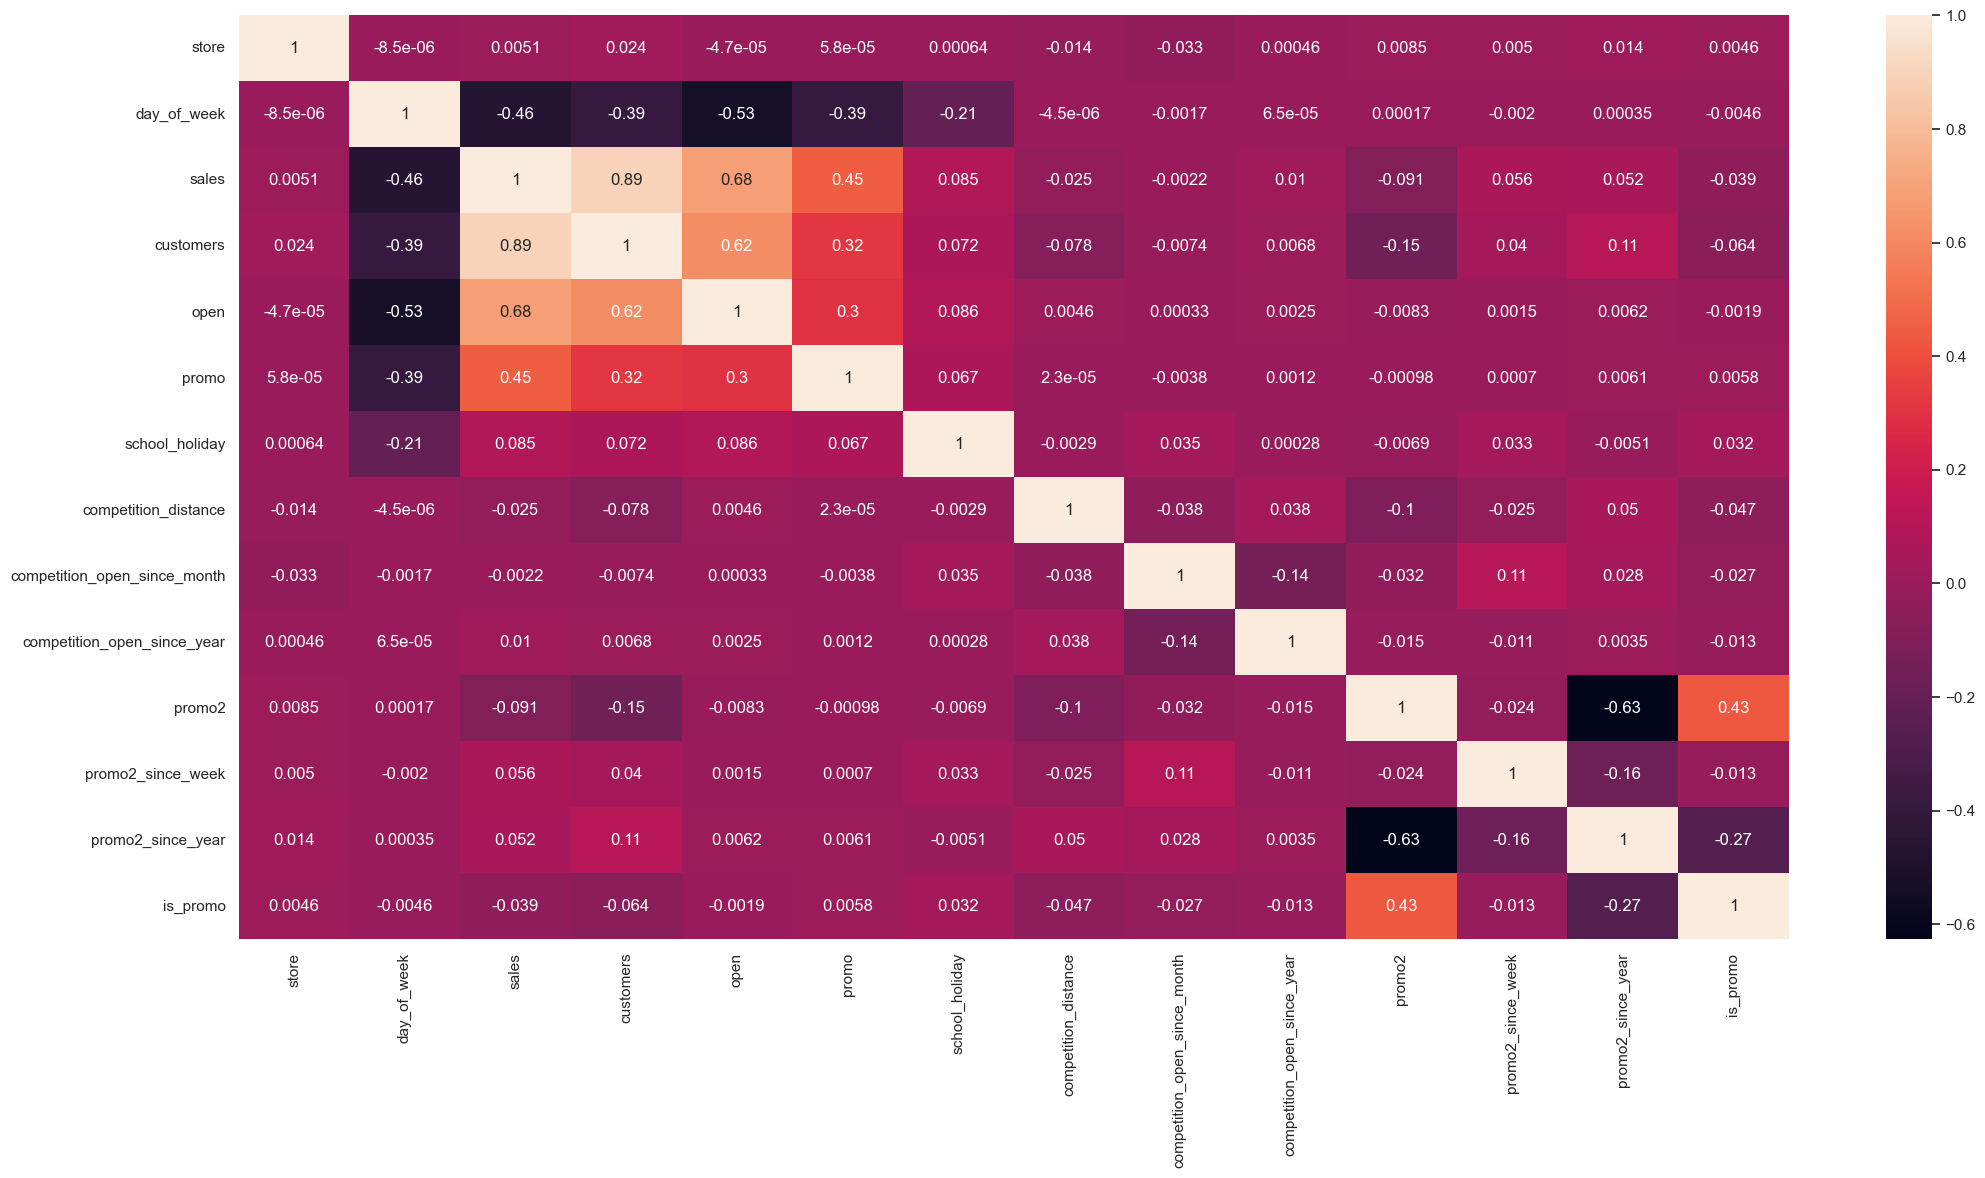

In [273]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2. Categorical Attributes

In [274]:
# only categorical data
cat = df4.select_dtypes( include='object' )
cat.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [275]:
# Calculate cramer V
cat1 = cramer_v( cat['state_holiday'], cat['state_holiday'] )
cat2 = cramer_v( cat['state_holiday'], cat['store_type'] )
cat3 = cramer_v( cat['state_holiday'], cat['assortment'] )
cat4 = cramer_v( cat['store_type'], cat['state_holiday'] )
cat5 = cramer_v( cat['store_type'], cat['store_type'] )
cat6 = cramer_v( cat['store_type'], cat['assortment'] )
cat7 = cramer_v( cat['assortment'], cat['state_holiday'] )
cat8 = cramer_v( cat['assortment'], cat['store_type'] )
cat9 = cramer_v( cat['assortment'], cat['assortment'] )

<Axes: >

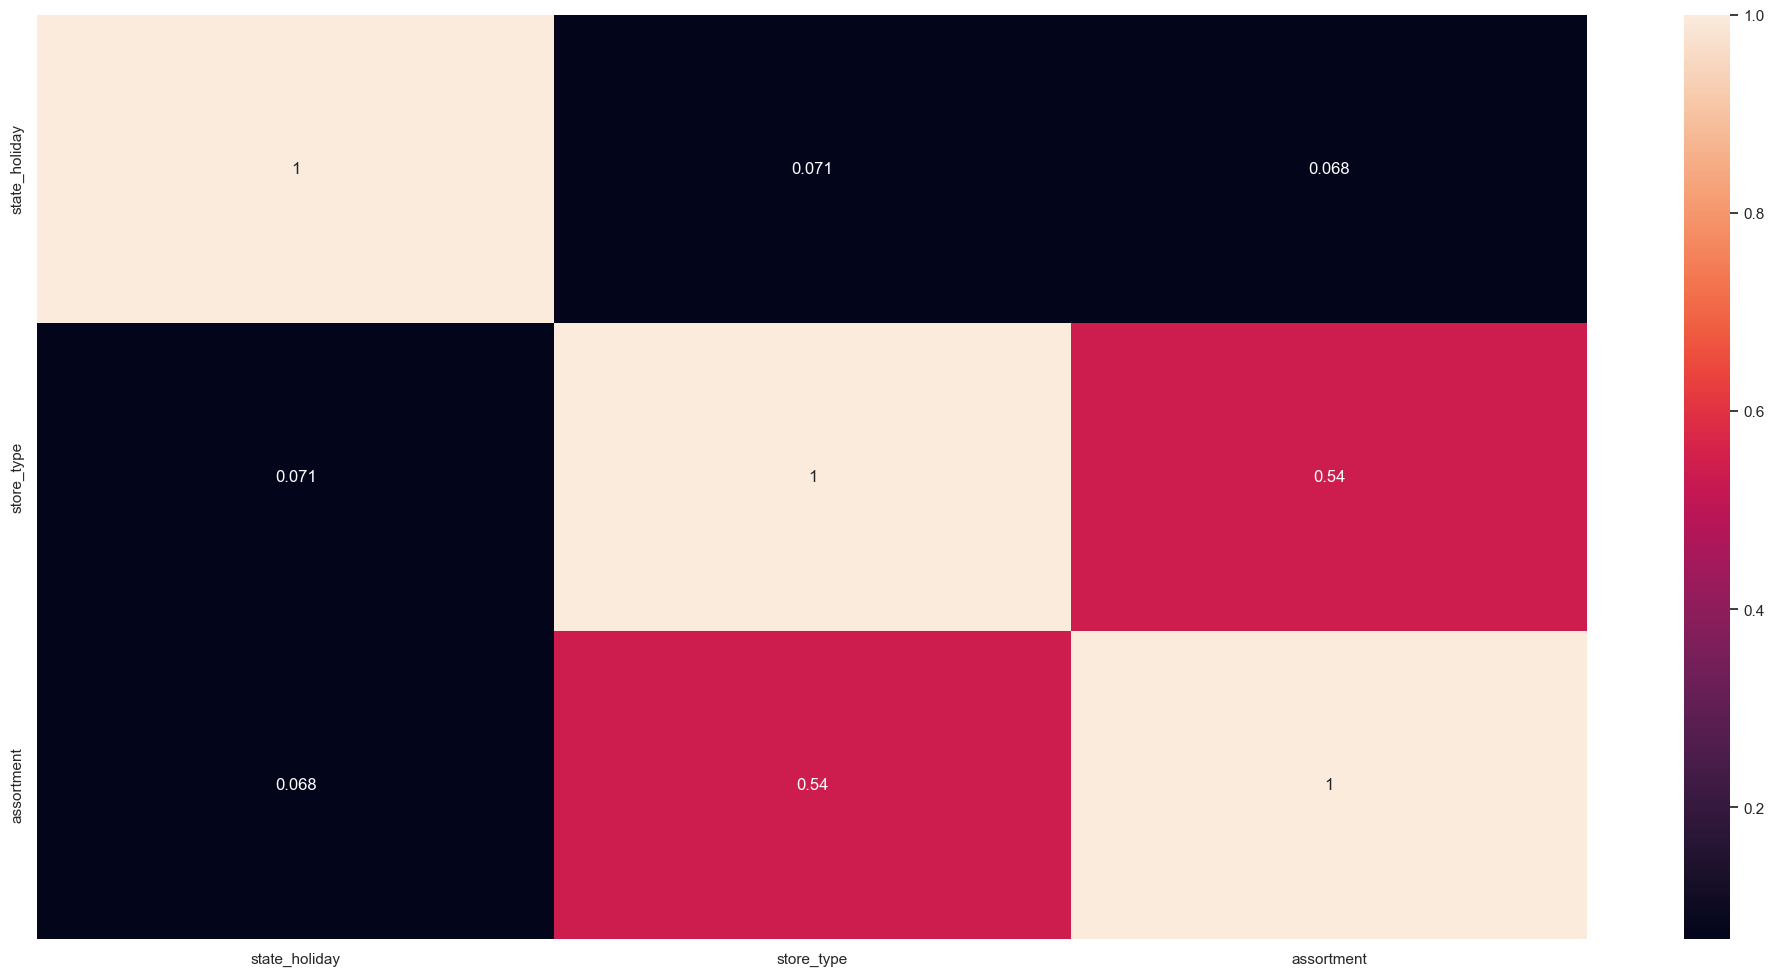

In [276]:
# Final dataset
final = pd.DataFrame( {'state_holiday': [cat1, cat2, cat3],
'store_type': [cat4, cat5, cat6],
'assortment': [cat7, cat8, cat9] })
final = final.set_index( final.columns )

sns.heatmap( final, annot=True )

# 5.0  Data Preparation

In [277]:
df5 = df4.copy()

## 5.1 - Normalizacao

** None of the numerical variable have a normal distribution, thus the normalization it's not fit.** 

## 5.2 - Rescaling

In [278]:
rs = RobustScaler()
mms = MinMaxScaler()


# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb') )

# competion time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump( rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb') )

## 5.3 - Transformação

### 5.3.1 Encoding

In [279]:
# state holiday - One hot encoding
df5 = pd.get_dummies(df5, prefix =['state_holiday'], columns=['state_holiday'] )


In [280]:
# store type - Label encoding
le = LabelEncoder()

df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )

In [281]:
# assortment - Ordinal encoding

assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3 }
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [282]:
# Trasnformação logaritmica na variável resposta - distribuição mais próxima da normal
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Nature Transformation

In [283]:
# day of week

df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2* np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2* np.pi/7 ) ) )

In [284]:
# month

df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * ( 2* np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2* np.pi/12 ) ) )

In [285]:
# day

df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * ( 2* np.pi/ 30) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * ( 2* np.pi/ 30) ) )

In [286]:
# week of year

df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2* np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2* np.pi/52 ) ) )

# 6.0 Feature Selection

In [287]:
df6 = df5.copy()

## 6.1 Split dataframe into training and dataset

In [288]:
# Excluir as variáveis originais das que originaram outras colunas

cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis =1)

In [289]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta (days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [290]:
# training dataset
X_train = df6 [df6['date'] < '2015-06-19']
y_train = X_train['sales']

In [291]:
# test dataset
X_test = df6 [df6['date'] >= '2015-06-19']
y_test = X_test['sales']

In [292]:
print (f'Training Min Date:{X_train["date"].min()}')
print (f'Training Min Date:{X_train["date"].max()}')
print (f'\nTest Min Date::{X_test["date"].min()}')
print (f'Test Min Date::{X_test["date"].max()}')

Training Min Date:2013-01-01 00:00:00
Training Min Date:2015-06-18 00:00:00

Test Min Date::2015-06-19 00:00:00
Test Min Date::2015-07-31 00:00:00


## 6.2 Boruta as feature selector

In [109]:
# training and test dataset for Boruta

#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()

# define RandomforestRegressor
#rf = RandomForestRegressor(n_jobs = -1)

# define boruta
#boruta = BorutaPy(rf , n_estimators = 'auto', verbose = 2, random_state=42).fit( X_train_n, y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1 Best features from boruta

In [111]:
# best_features

#cols_selected = boruta.support_.tolist()
#X_train_fs = X_train.drop (['date', 'sales'], axis =1)
#cols_selected_boruta = X_Train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta

#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta))

## 6.3 Manual Feature Selection

In [293]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']
# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 Machine Learning Modelling

In [294]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1 Average model

In [295]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']


# performance
baseline_result = ml_error ('Average Model', np.expm1(y_test), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear regression model

In [296]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [297]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear regression regularized model - Lasso

In [298]:
#model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1. Lasso - Cross Validation

In [299]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Regressor

In [300]:
#model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


### 7.4.1. Random Forest Regressor - Cross Validation

In [102]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17


## 7.5 XGBoost Regressor

In [107]:
# model
model_xgb =  xgb.XGBRegressor( objective='reg:squarederror',
                               n_estimators=100,eta=0.01,
                               max_depth=10,
                               subsample=0.7, 
                               colsample_bytree=0.9).fit( x_train, y_train )


# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1685.0258,0.250304,2463.213643


### 7.5.1. XGBoost Regressor - Cross Validation

In [104]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1859.87 +/- 289.14,0.25 +/- 0.01,2688.49 +/- 432.73


## 7.6. Compare Model’s Performance

### 7.6.1 Single Performance

In [105]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,Average Model,1354.800353,0.455051,1835.135542
0,XGBoost Regressor,1685.025800,0.250304,2463.213643
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.6.2. Real Performance - Cross Validation

In [106]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17
0,XGBoost Regressor,1859.87 +/- 289.14,0.25 +/- 0.01,2688.49 +/- 432.73


# 8.0  HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [55]:
#param = {
# 'n_estimators': [1500, 1700, 2500, 3000, 3500],
# 'eta': [0.01, 0.03],
# 'max_depth': [3, 5, 9],
# 'subsample': [0.1, 0.5, 0.7],
# 'colsample_bytree': [0.3, 0.7, 0.9],
# 'min_child_weight': [3, 8, 15]
# }


#MAX_EVAL = 5

#final_result = pd.DataFrame()

#for i in range( MAX_EVAL ):
    
    # choose values for parameters randomly

#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )

    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror', 
#                                  n_estimators=hp['n_estimators'],
#                                  eta=hp['eta'],
#                                  max_depth=hp['max_depth'],
#                                  subsample=hp['subsample'],
#                                  colsample_bytree=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )


    #performance
#    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#    final_result = pd.concat( [final_result, result] )
    
#final_result


{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 8}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 8}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 15}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 8}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2



,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,821.09 +/- 132.07,0.12 +/- 0.01,1189.26 +/- 197.54
0,XGBoost Regressor,1125.48 +/- 138.77,0.16 +/- 0.01,1613.71 +/- 179.66
0,XGBoost Regressor,807.98 +/- 117.38,0.11 +/- 0.01,1159.45 +/- 171.8
0,XGBoost Regressor,822.75 +/- 119.87,0.11 +/- 0.01,1179.88 +/- 169.12
0,XGBoost Regressor,879.85 +/- 126.33,0.12 +/- 0.01,1251.72 +/- 186.4


## 8.2. Final Model

In [301]:
param_tuned = {
'n_estimators': 1500,
'eta': 0.03,
'max_depth': 9,
'subsample': 0.5,
'colsample_bytree': 0.3,
'min_child_weight': 15
}

# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytree'], 
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,642.863362,0.092777,946.500221


In [302]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

0.004303049841608042

# 9.0 TRADUCAO E INTERPRETACAO DO ERRO

## 9.1. Business Performance

In [303]:
df9 = X_test[ cols_selected_boruta_full ].copy()

In [304]:
# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

In [305]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

In [306]:
# MAE and MAPE
df9_aux1 = (df9[['store', 'sales', 'predictions']].groupby( 'store' )
                                                  .apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) )
                                                  .reset_index()
                                                  .rename( columns={0:'MAE'}))
df9_aux2 = (df9[['store', 'sales', 'predictions']].groupby( 'store' )
                                                  .apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) )
                                                  .reset_index()
                                                  .rename( columns={0:'MAPE'}))


In [307]:
# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )


In [308]:
# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

In [309]:
# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]

In [310]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,103305.000000,99925.444040,106684.555960,3379.555960,0.557531
908,909,231008.140625,223354.295240,238661.986010,7653.845385,0.510516
594,595,360043.906250,355471.768792,364616.043708,4572.137458,0.312065
875,876,206482.031250,202532.172862,210431.889638,3949.858388,0.295010
721,722,345629.218750,343836.429437,347422.008063,1792.789313,0.241716


<Axes: xlabel='store', ylabel='MAPE'>

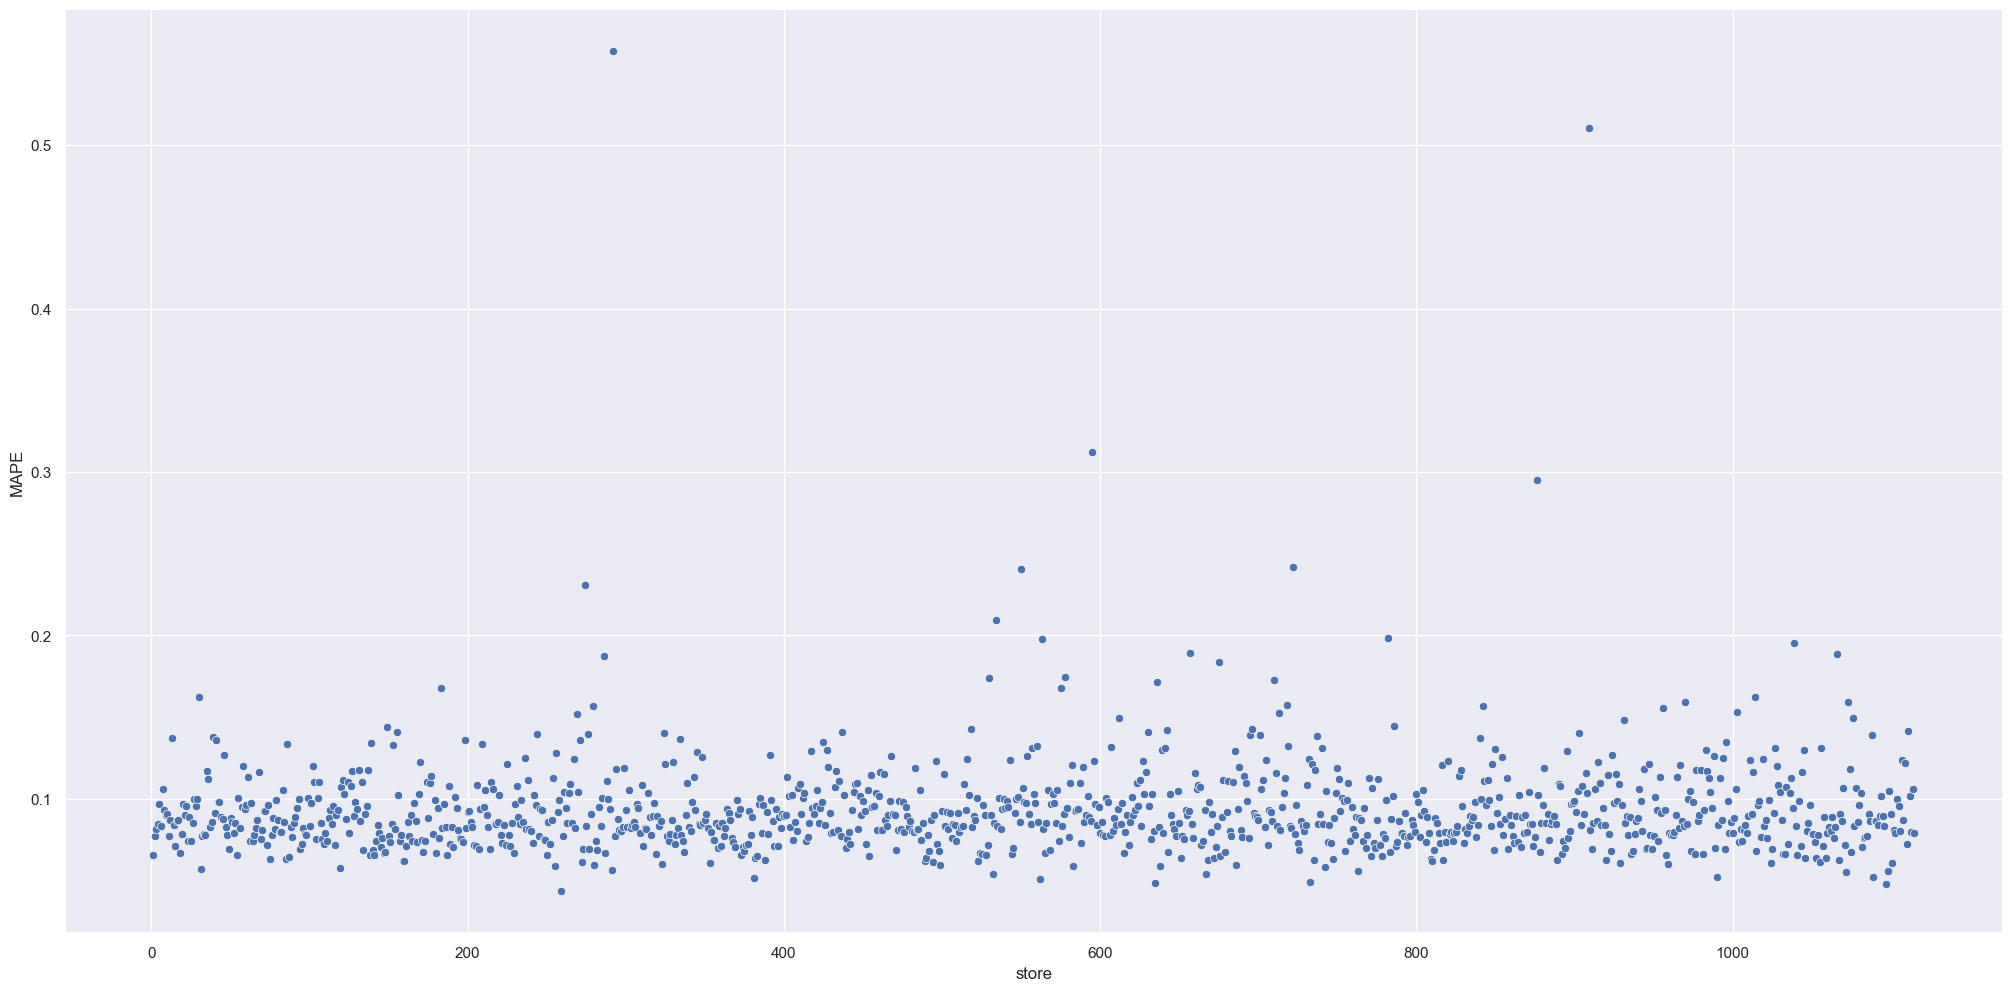

In [311]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

## 9.2. Total Performance

In [312]:
df93 = (df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x:np.sum( x ), axis=0 )
                                                                .reset_index()
                                                                .rename( columns={'index': 'Scenario', 0:'Values'} ))
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$283,317,760.00"
1,worst_scenario,"R$282,596,899.51"
2,best_scenario,"R$284,038,602.71"


## 9.3. Machine Learning Performance

In [313]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<Axes: xlabel='predictions', ylabel='error'>

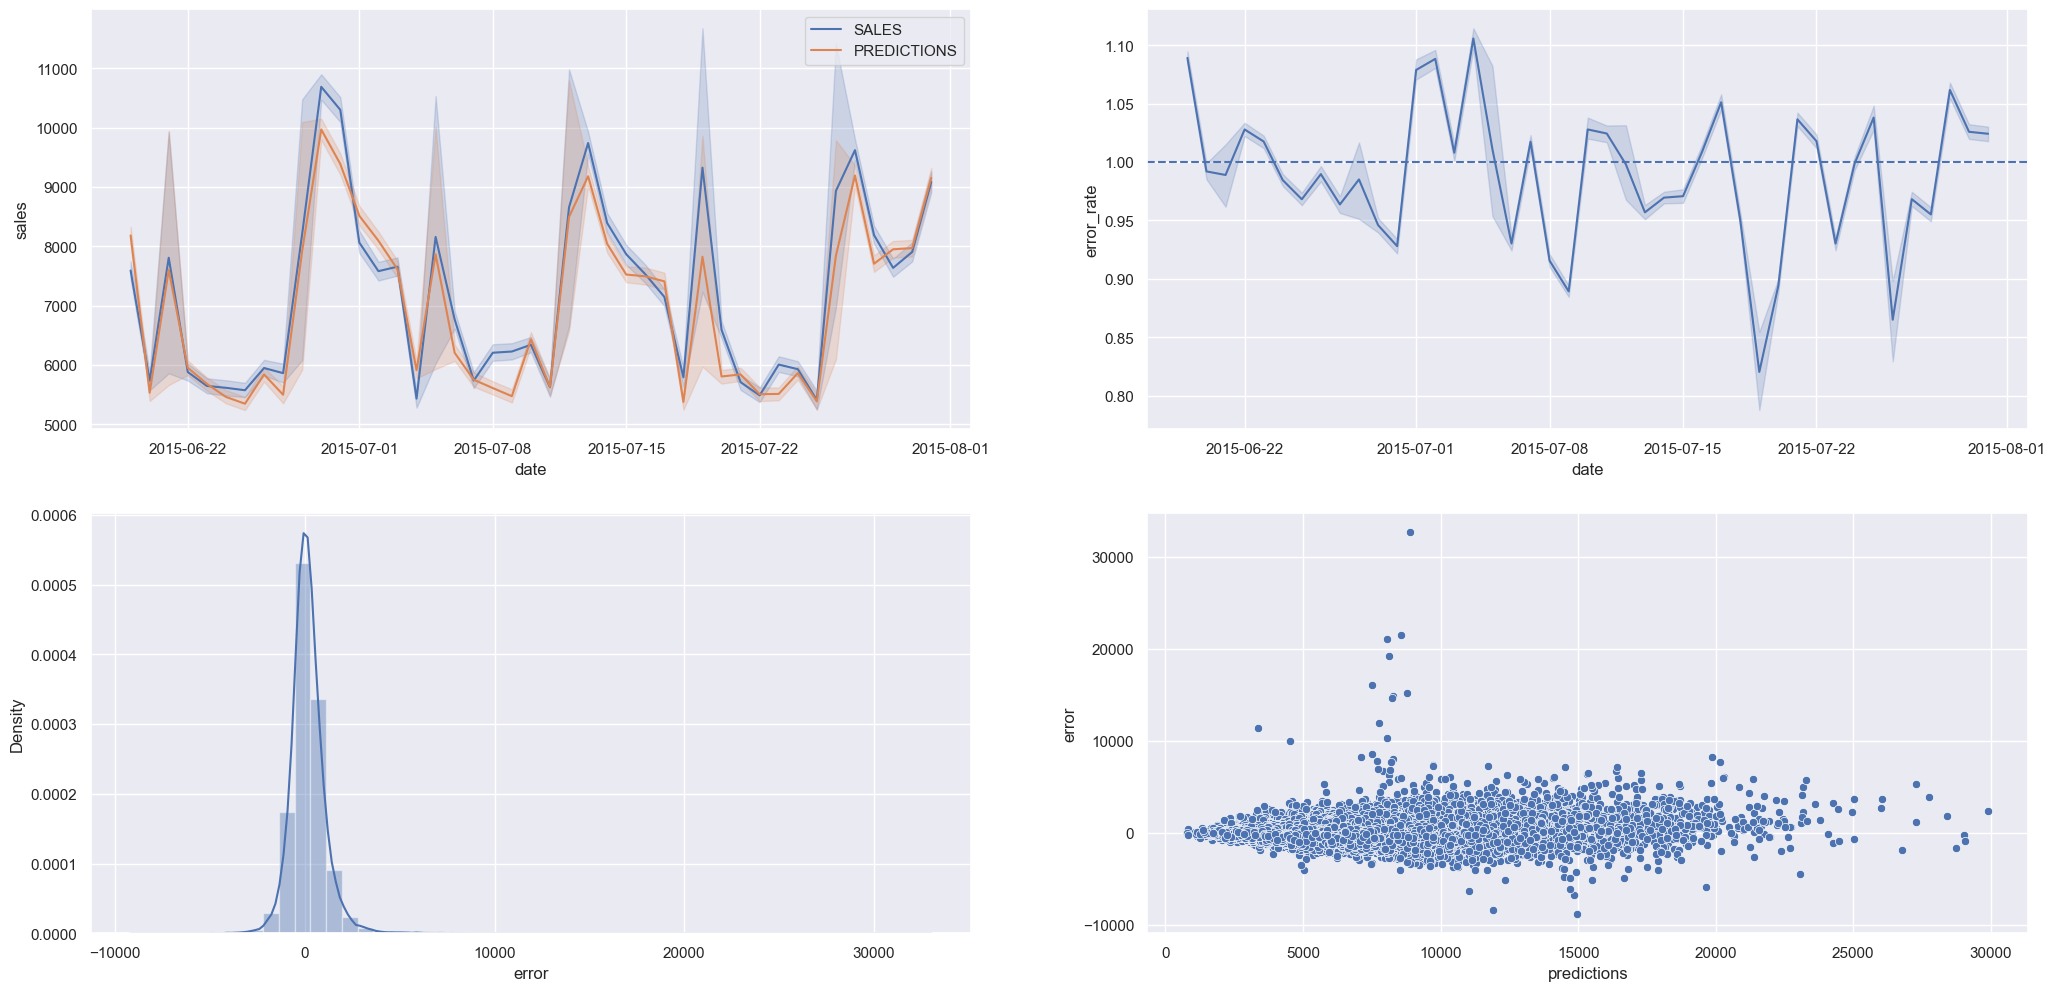

In [314]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )
plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')
plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )
plt.subplot( 2, 2, 4 )
sns.scatterplot(x='predictions', y='error', data=df9)

# 10. DEPLOY MODEL TO PRODUCTION

In [315]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open( '/Users/Leona/Documentos/repos/ds_prod/model/model_rossmann.pkl', 'wb' ) )

## 10.1. Rossmann Class

In [334]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):

        self.home_path='/Users/Leona/Documentos/repos/ds_prod/'
        self.competition_distance_scaler = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )

    def data_cleaning( self, df1 ):

        ## 1.1 Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                   'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                   'CompetitionDistance', 'CompetitionOpenSinceMonth',
                   'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                   'Promo2SinceYear', 'PromoInterval']

        
        snakecase = lambda x: inflection.underscore (x)
        
        cols_new = list(map(snakecase, cols_old))
        
        #rename
        df1.columns = cols_new

        ## 1.3 Data Types
        df1['date'] = pd.to_datetime(df1['date'])
        
        ## 1.5 Fillout NA
        #competition_distance   
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan ( x ) else x)
                                          
        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply (lambda x: x['date'].month if math.isnan (x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)
        
        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan (x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)
        
        #promo2_since_week  
        df1['promo2_since_week'] = df1.apply (lambda x: x['date'].week if math.isnan (x['promo2_since_week']) else x['promo2_since_week'], axis = 1)
        
        #promo2_since_year   
        df1['promo2_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan (x['promo2_since_year']) else x['promo2_since_year'], axis = 1)
        
        #promo_interval       
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        
        # Substituo os NA por 0 e o inplace faz direto na coluna
        df1['promo_interval'].fillna(0, inplace=True )
        
        # Crio a coluna month_map usando a coluna da data. O dt consegue trabalhar com series, o month pega o mês e o mapa faz uma função parecida com o apply
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        df1['is_promo'] = df1[['promo_interval','month_map']].apply (lambda x:0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1)
        
        
        ## 1.6 Change Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )
        
        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )

        return df1

    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year
        # month
        df2['month'] = df2['date'].dt.month
        # day
        df2['day'] = df2['date'].dt.day
        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')
        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )
        
        # competition since
        df2 ['competition_since'] = df2.apply( lambda x: datetime.datetime ( year = x['competition_open_since_year'],
                                                                             month = x['competition_open_since_month'], 
                                                                             day = 1), axis = 1)
        
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply( lambda x: x.days).astype( 'int64' )
        
        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply( lambda x: x.days).astype( 'int64' )
        
        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' 
                                                                       else 'extra' if x == 'b' 
                                                                       else 'extended' )
        
        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a'
                                                                                      else 'easter_holiday' if x == 'b'
                                                                                      else 'christmas' if x == 'c' 
                                                                                      else 'regular_day' )
        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]
        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2

    def data_preparation( self, df5 ):

        ## 5.2. Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )
        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )
        
        ### 5.3.1 Encoding
        # state holiday - One hot encoding
        df5 = pd.get_dummies(df5, prefix =['state_holiday'], columns=['state_holiday'] )
        
        # store type - Label encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )
        
        # assortment - Ordinal encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3 }
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2* np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2* np.pi/7 ) ) )
        
        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * ( 2* np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2* np.pi/12 ) ) )
        
        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * ( 2* np.pi/ 30) ) )
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * ( 2* np.pi/ 30) ) )
        
        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2* np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2* np.pi/52 ) ) )

        cols_selected = [
            'store',
            'promo',
            'store_type',
            'assortment',
            'competition_distance',
            'competition_open_since_month',
            'competition_open_since_year',
            'promo2',
            'promo2_since_week',
            'promo2_since_year',
            'competition_time_month',
            'promo_time_week',
            'day_of_week_sin',
            'day_of_week_cos',
            'month_sin',
            'month_cos',
            'day_sin',
            'day_cos',
            'week_of_year_sin',
            'week_of_year_cos']
        
        return df5[ cols_selected ]

    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2. API Handler

In [327]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( '/Users/Leona/Documentos/repos/ds_prod/model/model_rossmann.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )

def rossmann_predict():
    test_json = request.get_json()
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
        # Instantiate Rossmann class
        pipeline = Rossmann()
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        return df_response

    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '127.0.0.1', debug = True )

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

## 10.3. API Tester

In [335]:
import json

In [336]:
# loading test dataset
df10 = pd.read_csv( '/Users/Leona/Documentos/repos/ds_prod/Data/test.csv' )

In [337]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [20,23,22]) ]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [338]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [340]:
# API Call
url = 'http://127.0.0.1:5000/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data
r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [341]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [342]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format (d2.loc[i, 'store'], d2.loc[i, 'prediction'] ) )

Store Number 20 will sell R$283,771.22 in the next 6 weeks
Store Number 22 will sell R$227,806.01 in the next 6 weeks
Store Number 23 will sell R$227,976.83 in the next 6 weeks
